# LFP dataset example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(10)

# Test your implementations of the skewness and kurtosis etc. 
from scipy.stats import skew
from scipy.stats import kurtosis

from jax import jacfwd
import jax.numpy as jnp

import src.featlin
from src.featlin import Featlin
# from src.featlin import regress_linearized_coeff
from src.featlin import jax_moment
# from src.featlin import linearization_plots
# from src.featlin import linearization_regeression_row_plots

from src.helper import optimise_pls_cv
from src.helper import optimize_regcoef_nrmse
from src.helper import optimize_regcoef_dist
from src.helper import plot_x_tt2

import src.basis as basis
from src.basis import BasicsData

plt.style.use('./styles/plots.mplstyle')

%load_ext autoreload
%autoreload 2

In [35]:
save_plots = 0
save_path = './results/Linearization/'

In [3]:
# Colorblind safe palette from: https://gka.github.io/palettes/#/26|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1 
# IBM Colors: https://www.ibm.com/design/language/color/
# https://lospec.com/palette-list/ibm-color-blind-safe

colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
colors_IBM = ['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000',  '#000000']
cmap_ = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-IBM', colors_IBM[:-1], N=256)
color_list = [colors_IBM[0], colors_IBM[2], colors_IBM[3], colors_IBM[4], colors_IBM[5]]
marker_list = ['s', 'o', 'D', 'P']

In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv('./data/lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

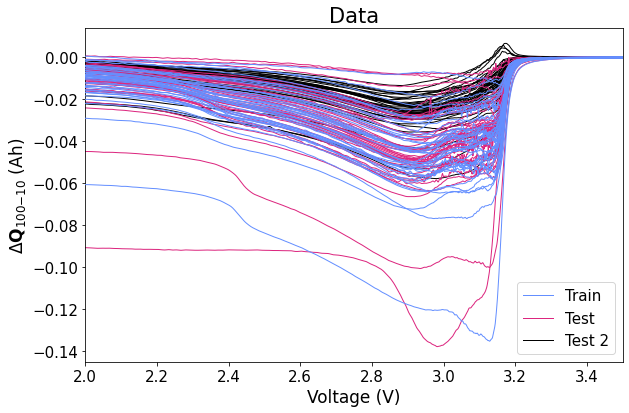

In [5]:
# Make Dataset Plots. 
fig, ax = plt.subplots(figsize=(9,6))
ax = src.helper.plot_x_tt2(X_lfp_train, x_lfp, ax, colors_IBM[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], zorder=3)
ax = src.helper.plot_x_tt2(X_lfp_test, x_lfp, ax, colors_IBM[2], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Test', zorder=2)
ax = src.helper.plot_x_tt2(X_lfp_test2, x_lfp, ax, colors_IBM[5], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Test 2', zorder=1)
ax.set_title('Data')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'data.pdf')

In [22]:
# Remove outlier 
id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

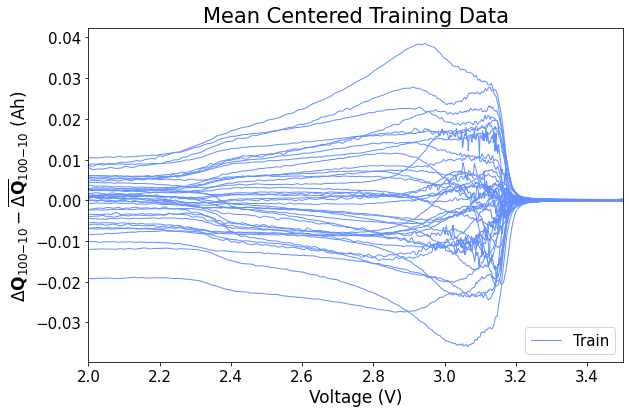

In [36]:
fig, ax = plt.subplots(figsize=(9,6))
ax = src.helper.plot_x_tt2(X_lfp_train-np.mean(X_lfp_train, axis=0), x_lfp, ax, colors_IBM[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Train')
ax.set_ylabel(r'$\Delta \mathbf{Q}_{100\mathrm{-}10} - \overline{\Delta \mathbf{Q}}_{100\mathrm{-}10}$ (Ah)')
ax.set_title('Mean Centered Training Data')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'mctrain.pdf')
plt.show()

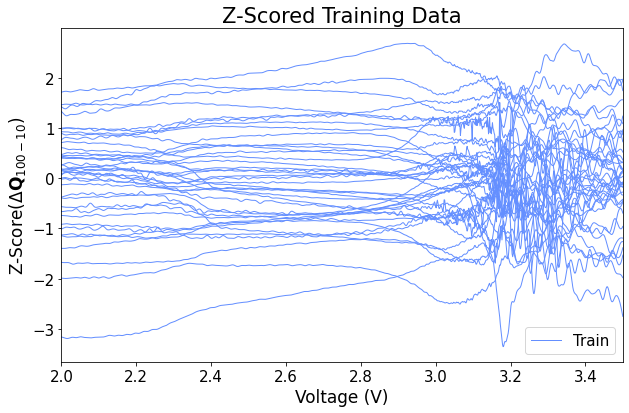

In [37]:
scaler = StandardScaler()
X_zscore = scaler.fit_transform(X_lfp_train)

fig, ax = plt.subplots(figsize=(9,6))
ax = src.helper.plot_x_tt2(X_zscore, x_lfp, ax, colors_IBM[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Train')
ax.set_ylabel(r'Z-Score$(\Delta \mathbf{Q}_{100-10})$')
ax.set_title('Z-Scored Training Data')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'zscoretrain.pdf')
plt.show()

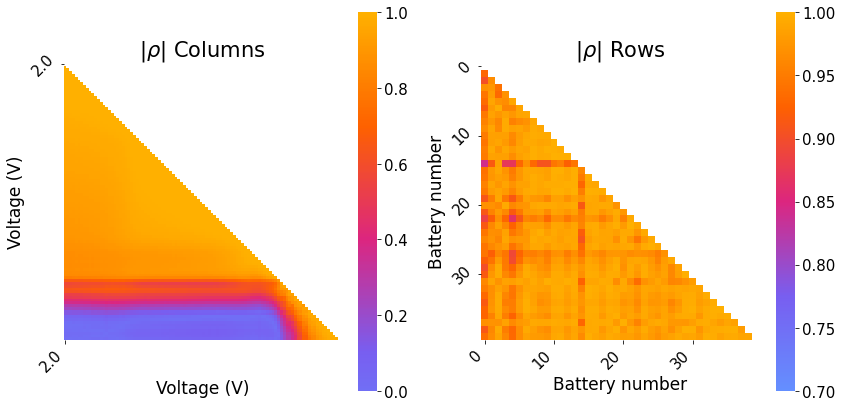

In [38]:
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=y_lfp_train_true) 

# Correlations: 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs = lfp_mean.plot_row_column_corrheatmap(labels_lfp['xdata_label'], labels_lfp['row_label'], axs=axs)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'corr.pdf')

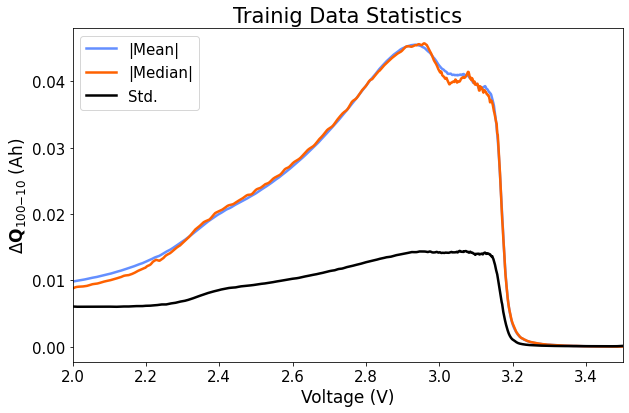

In [39]:
fig, ax = plt.subplots(figsize=(9,6))
axs = lfp_mean.plot_stats(ax, colors_IBM[0], colors_IBM[5], colors_IBM[3], labels_lfp['xdata_label'], labels_lfp['ydata_label'])
ax.set_title('Trainig Data Statistics')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'stats.pdf')
plt.show()

# Ground Truth Features
- Mean 
- Varinace
- Sum of Squares
- Skewness


In [27]:
# True underlying relationship between the measurements and some quantity we ewould like to recover/predict from measurements

# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda a : jnp.mean(a),
    lambda a : jnp.sum(a**2),
    lambda a : jnp.var(a),
    lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2)),
    lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    ]
fun_target_names = [
    'Sum',
    'Sum of Squares',
    'Variance', 
    'Skewness',
    'Kurtosis',
    ]
feat_fun_dict = {fun_target_names[i] : fun_targetj[i] for i in range(len(fun_targetj))}

# What if the relationship is actually a combination fo different functions
# Combinations based of the functions above to obtain non-linear functions of different complexity
# This is expected to show limits of the methodology
fun_target_combj = [
    lambda  a : np.array(5*fun_targetj[0](a) + fun_targetj[1](a)),
    lambda  a : np.array(3*fun_targetj[2](a) + fun_targetj[0](a)),
    lambda  a : np.array(fun_targetj[1](a) * fun_targetj[3](a)),
    lambda  a : np.array(fun_targetj[3](a) * fun_targetj[4](a))
    ]
ftarget_comb_names = [
    '5*\sum_{i=1}^n x_i + \sum_{i=1}^n x_i^2',
    '3*\text{var}(\mathbf{x}) + \sum_{i=1}^n x_i',
    '\sum_{i=1}^n x_i^2 * \text{skewness}(\mathbf{x})',
    '\text{skewneww}(\mathbf{x}) * \text{kurtosis}(\mathbf{x})'
]

# X = X_lfp_train-np.mean(X_lfp, axis=0)
# y_gt = np.zeros([X.shape[0], 5, 1])
# for j in range(len(fun_targetj)): 
#     y_gt[:, j, 0] = generate_target_values(X[:, :], fun_targetj[j], percentage_range_x_to_t=[0,1], snr=50)

In [28]:
# Generate BasicsData class objects
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Mean
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Sum Squares
lfp_sums = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_sums = lfp_sums.construct_y_data(fun_targetj[1]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Variance
lfp_var = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_var = lfp_var.construct_y_data(fun_targetj[2]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Skew
lfp_skew = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_lfp_skewvar = lfp_skew.construct_y_data(fun_targetj[3]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Kurt
lfp_kurt = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_kurt = lfp_kurt.construct_y_data(fun_targetj[4]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

In [29]:
# Inititate the class with data (x, y) & features that you want to test
lfp_meangt = Featlin(data_obj=lfp_mean, feat_funcs=feat_fun_dict)

['PLS 5 comp', 'lfun']
inf
['PLS 1 comp', 'lfun']
4.353963766290381e-05
0.0008265421412118057
0.015467671348702083
0.15506843375043156
0.015467671348702083
0.030718174021613476
0.05780848829081253
0.10000764191425526
0.15506843375043156
0.10000764191425526
0.1128279598270232
0.12637938877572297
0.1405168001996151
0.15506843375043156
0.1405168001996151
0.14412307905249944
0.14775243842701302
0.15140190250514896
0.14775243842701302
0.14866303729550534
0.1495748458782269
0.15048781681099177
4
Gamma value corresponding to nrmse=0.15 % is 18.811
18.81109438449698
['PLS 1 comp', 'lfun']
0.0008454391517216386
0.015913064358148765
0.18067187614878266
0.015913064358148765
0.02938463483948095
0.053377032128158364
0.09762592420259475
0.18067187614878266
0.09762592420259475
0.11376679634076692
0.1326710085265017
0.15479953891868625
0.1326710085265017
0.13788157218469976
0.14330114104262281
0.1489377186872025
0.15479953891868625
0.1489377186872025
0.1503817305767161
4
Gamma value corresponding to n

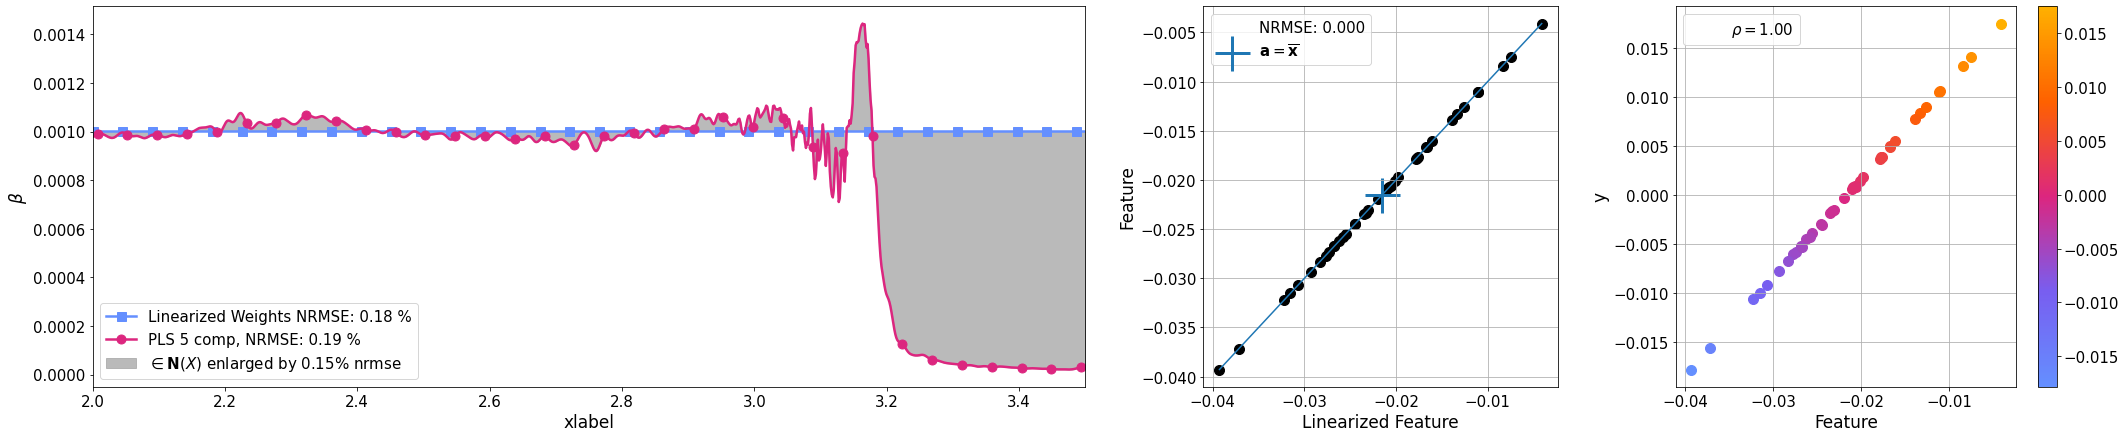

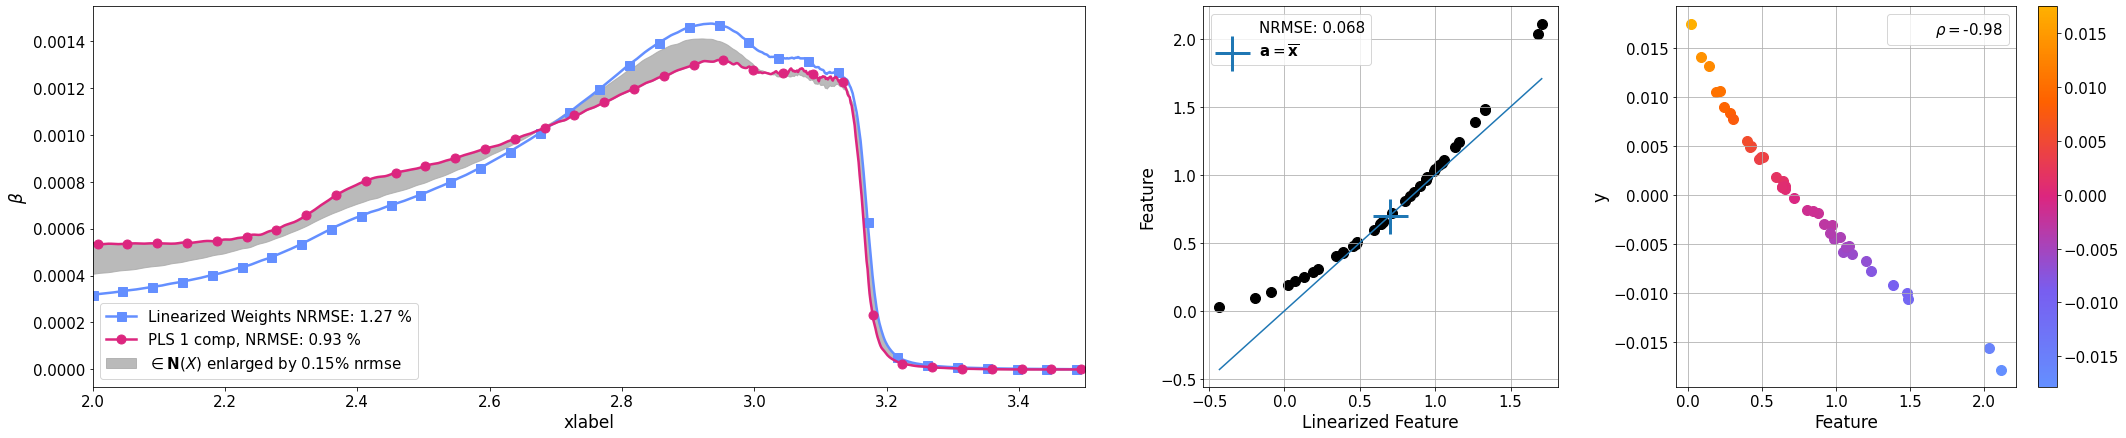

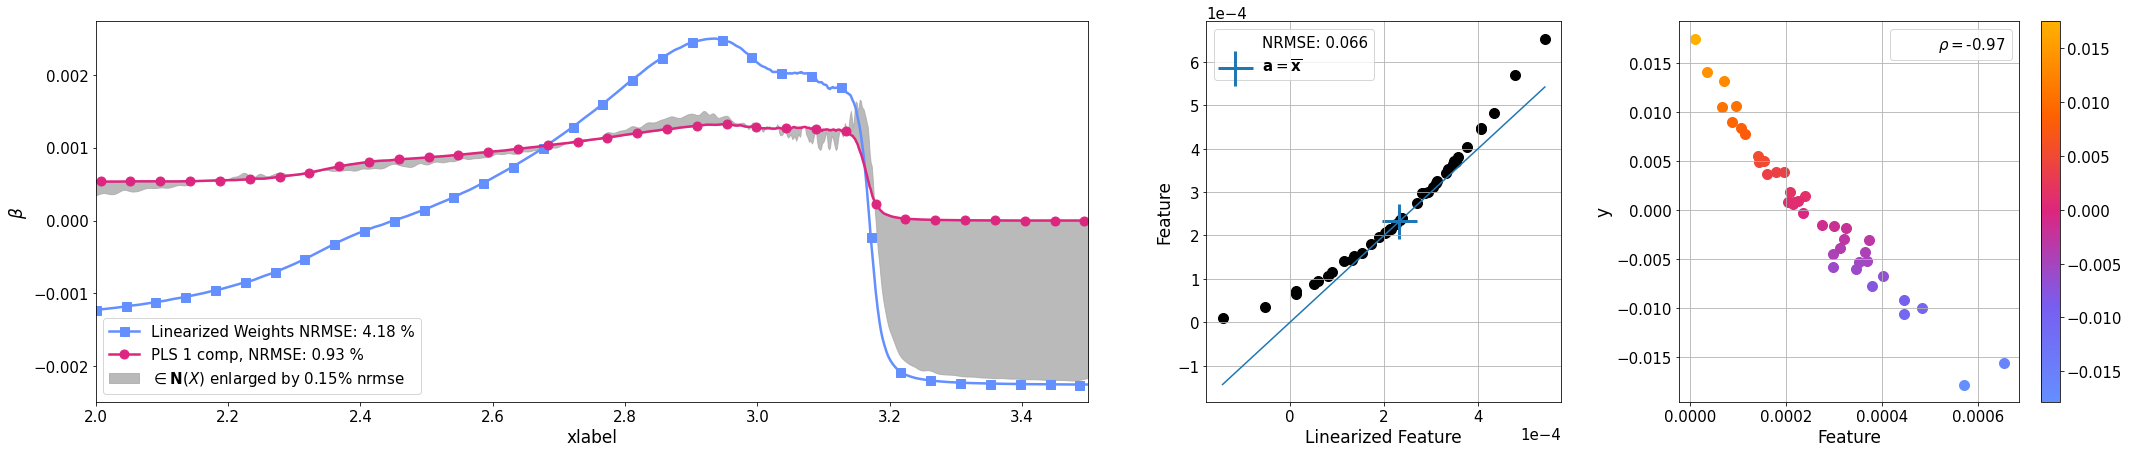

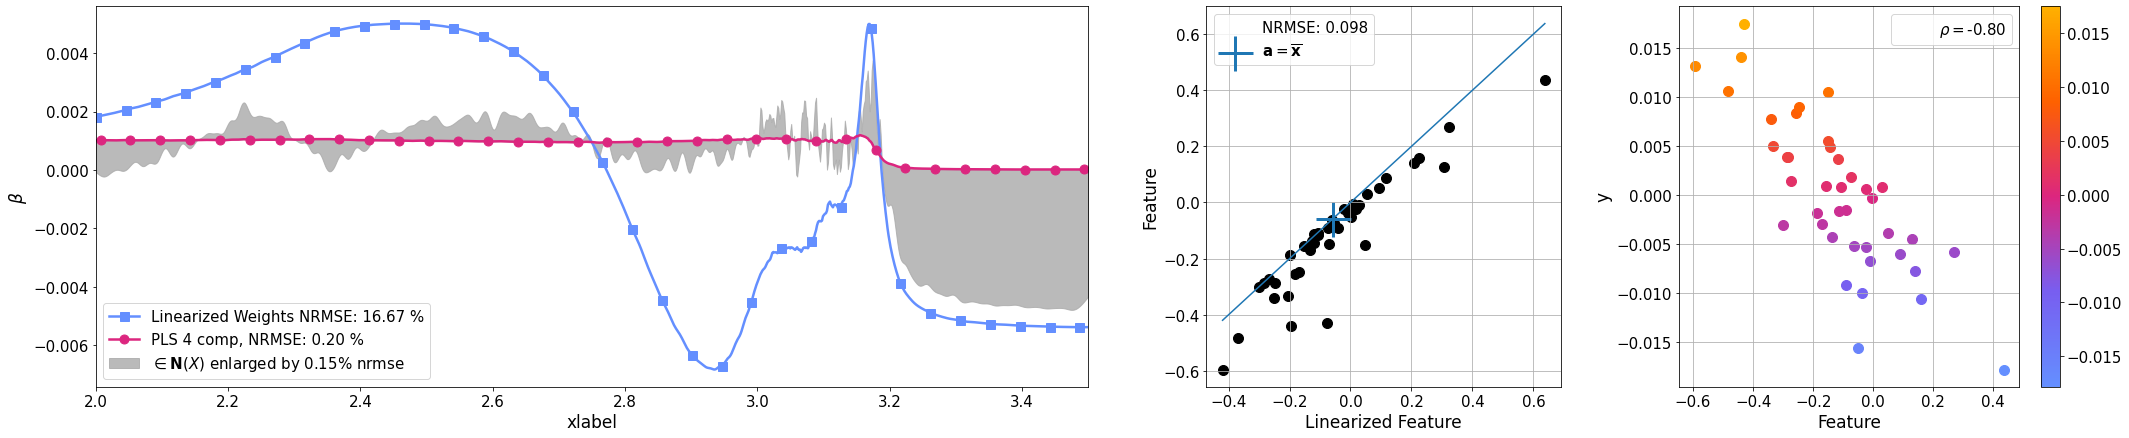

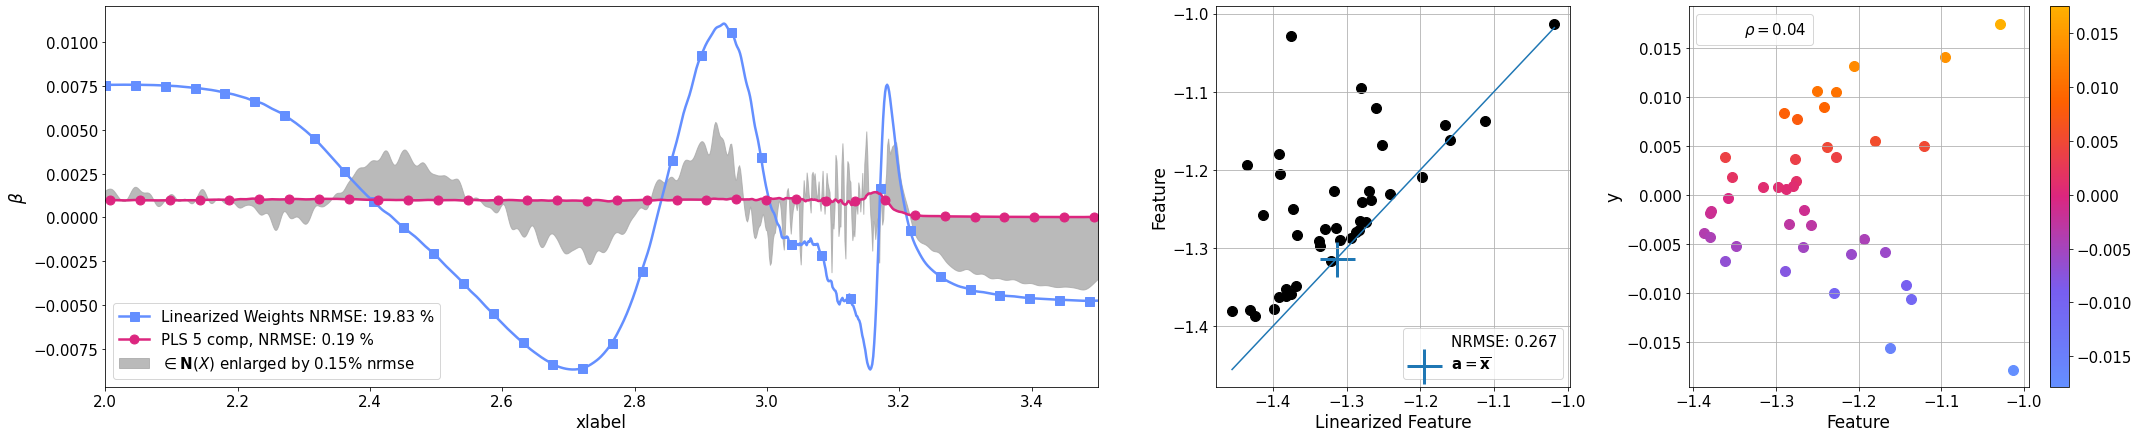

In [30]:
lfp_meangt = lfp_meangt.analyse_all_features(opt_nrmse=0, max_nrmse=0.15, opt_dist=1)

In [31]:
# Then still the question remains, how to select the feature. 
# If the true feature is linear, easy. 
# If the true feature is nonlinear, then we're strongly limited
# By what we can show with thelinearized case.
# The linearized coefficients will make a mistake. 
# The nonlinear coefficients will make a mistake too. 
# Maybe we need to compare prediction between linearized 
# coefficients and regression coefficients? 

# Otherwise the meaning of thre prediction accouracy will be hard to compare. 

# Write functions that creates reuslts table: 

#Feature #NRMSE_Linearized #Closest_PLS_Model #NRMSE_PLS #Closest_RR_Model #NRMSE_RR #Pearson_Corr_Coefficient

# Assuming the featue IS the ground truth, which model predicts closes to it? 
# --> Select the feature! Which feature predicts closest to the linearized feature. Take th

# 1. Select with Pearson correlation coefficeints
# 2. Get insights into the feature with the linearization approach.
# 3. 


In [32]:
# 5. Show result table

['PLS 1 comp', 'lfun']
inf
['PLS 1 comp', 'lfun']
inf
['PLS 1 comp', 'lfun']
0.001680374975461696
0.0019850863973935873
0.09729750207805754
0.8862922400476307
0.09729750207805754
0.18643576470538292
0.34087689731354054
0.5784523392943877
0.34087689731354054
0.3922772933226568
0.44909674810332856
0.5112437470932836
0.44909674810332856
0.46414133589080464
0.47951667203324977
0.4952189740367787
0.5112437470932836
0.4952189740367787
0.4991951270004158
0.5031913606809724
4
Gamma value corresponding to nrmse=0.50 % is 44.709
44.708554124166334
['PLS 2 comp', 'lfun']
0.0031636024190162537
0.016725478156329743
0.21951126880925953
2.5154321975603007
0.21951126880925953
0.3934591074829119
0.7445003066575819
0.3934591074829119
0.45940392992702295
0.5382733009944087
0.45940392992702295
0.47781944636017526
0.4970779632301672
0.517216618033236
0.4970779632301672
0.5020286462067056
4
Gamma value corresponding to nrmse=0.50 % is 116.260
116.25983105011949
['PLS 2 comp', 'lfun']
0.007278905300255989
0.

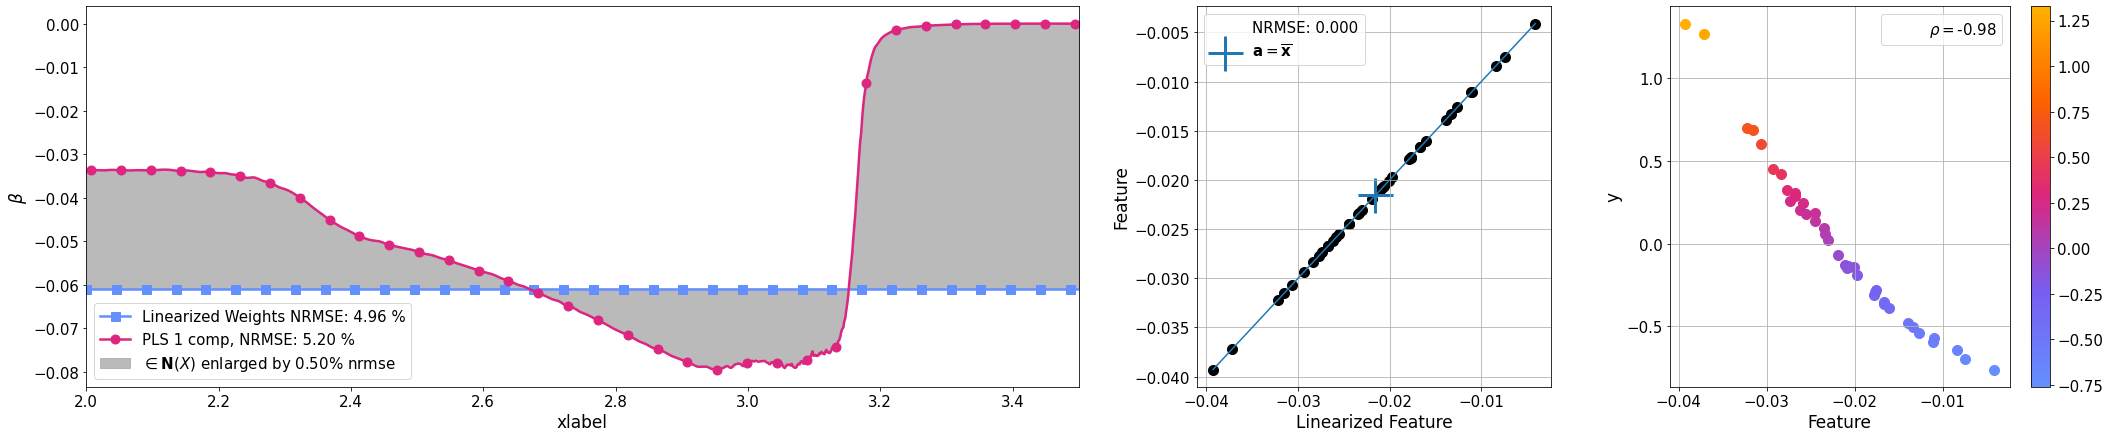

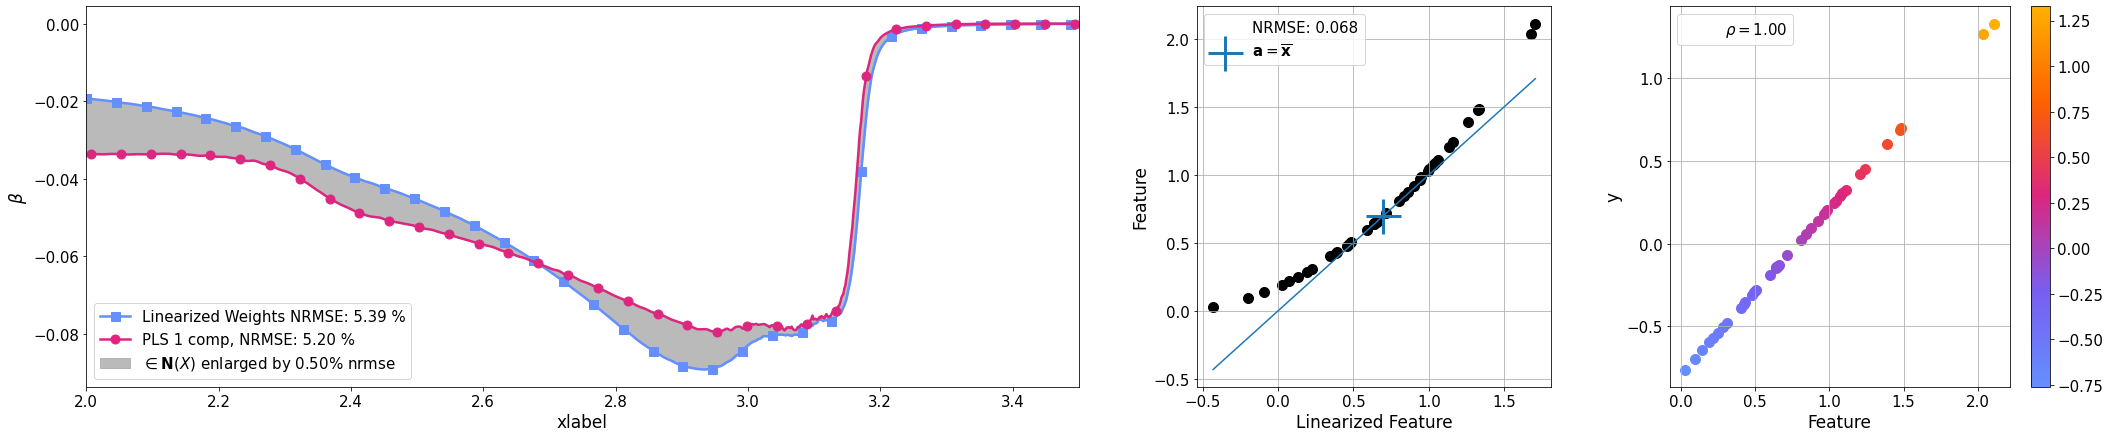

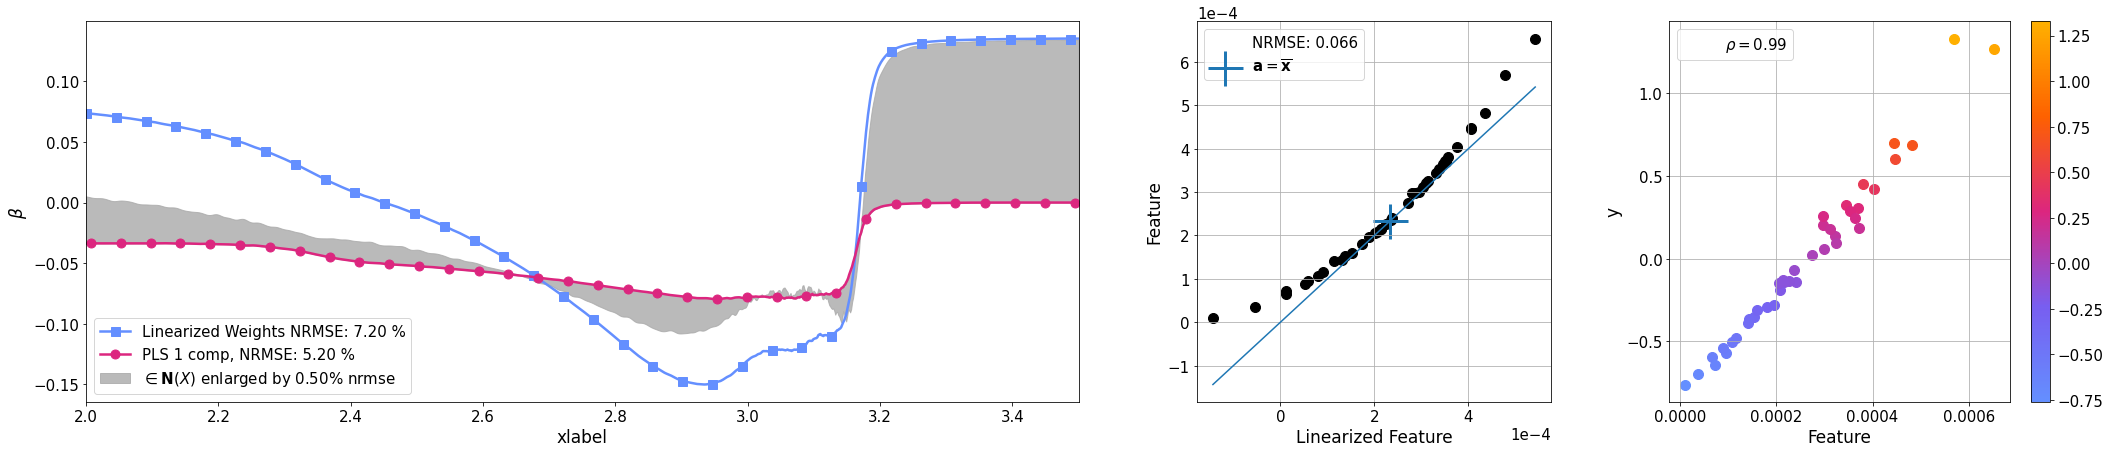

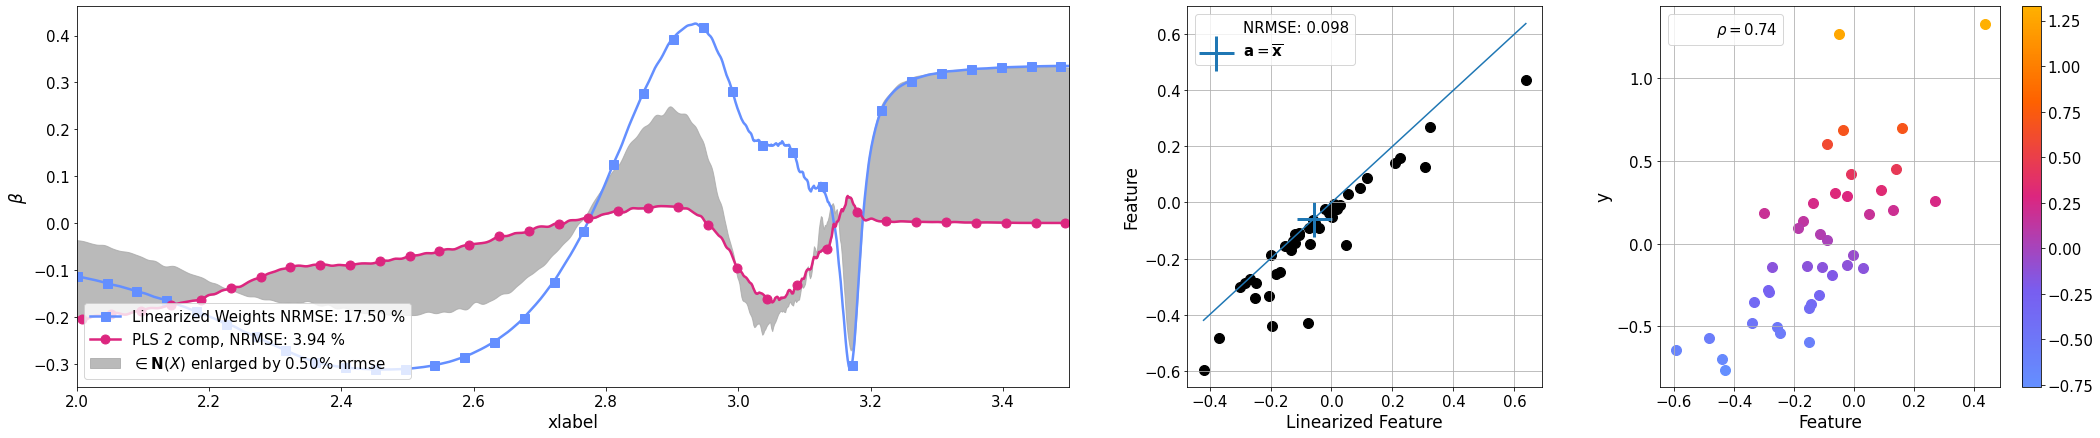

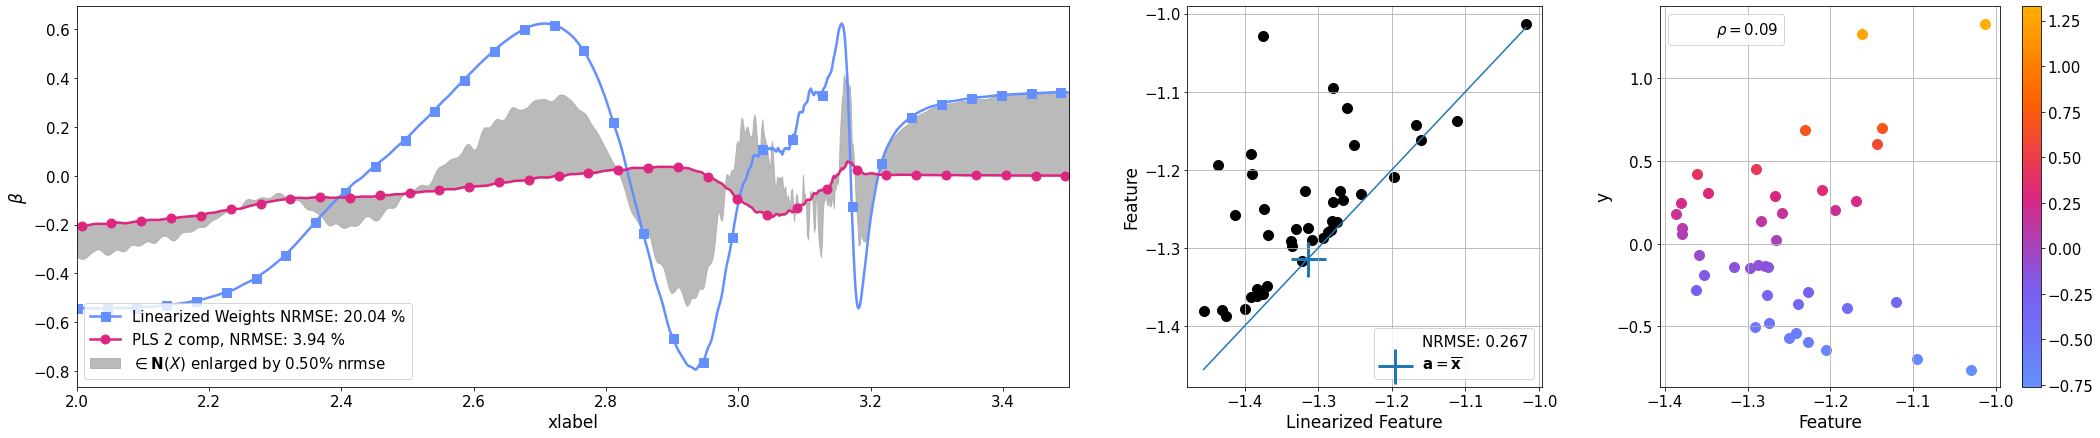

In [34]:
# Inititate the class with data (x, y) & features that you want to test
lfp_sums_gt = Featlin(data_obj=lfp_sums, feat_funcs=feat_fun_dict)

# Run the tests
lfp_sums_gt = lfp_sums_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.50, opt_dist=1)
plt.show()

['PLS 1 comp', 'lfun']
inf
['PLS 1 comp', 'lfun']
inf
['PLS 2 comp', 'lfun']
0.0019749638878137077
0.0007159927833733093
0.07484137804626201
0.48840848687247096
0.8654606282652484
0.48840848687247096
0.6365917500820757
0.48840848687247096
0.5272204128772451
0.48840848687247096
0.4981540103324873
0.5078776849501194
0.4981540103324873
0.5005873613961969
4
Gamma value corresponding to nrmse=0.50 % is 16.811
16.810705403586443
['PLS 1 comp', 'lfun']
0.003039636440175464
0.00534434375764814
0.08232234149876749
2.4024007896481576
0.08232234149876749
0.22339098074136654
0.5634304319105725
0.22339098074136654
0.28382068239773606
0.3588322823068353
0.4511060904313755
0.5634304319105725
0.4511060904313755
0.4771981251539774
0.5045873023009175
0.4771981251539774
0.4839221073591595
0.4907278443415235
0.49761601642784825
0.5045873023009175
4
Gamma value corresponding to nrmse=0.50 % is 82.047
82.04696109024991
['PLS 1 comp', 'lfun']
0.004411705782171538
0.02148439461128593
0.44820171702357037
2.627

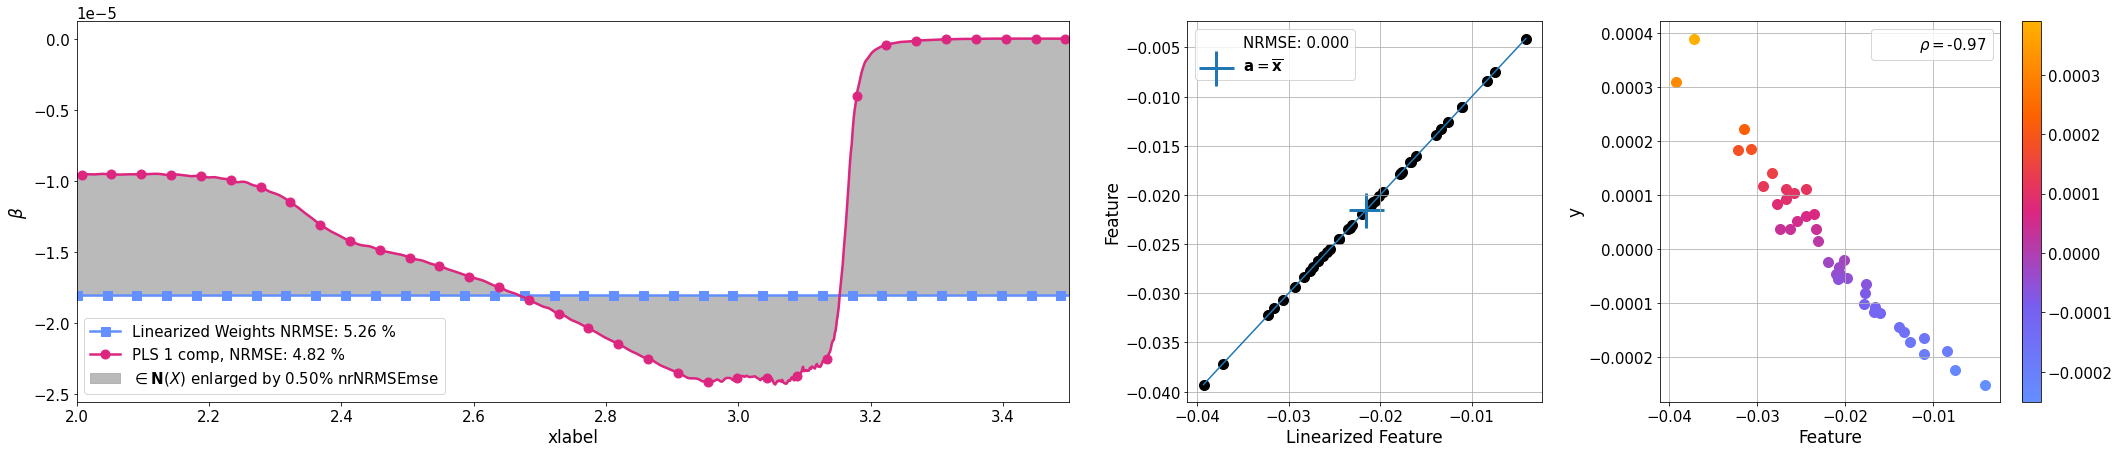

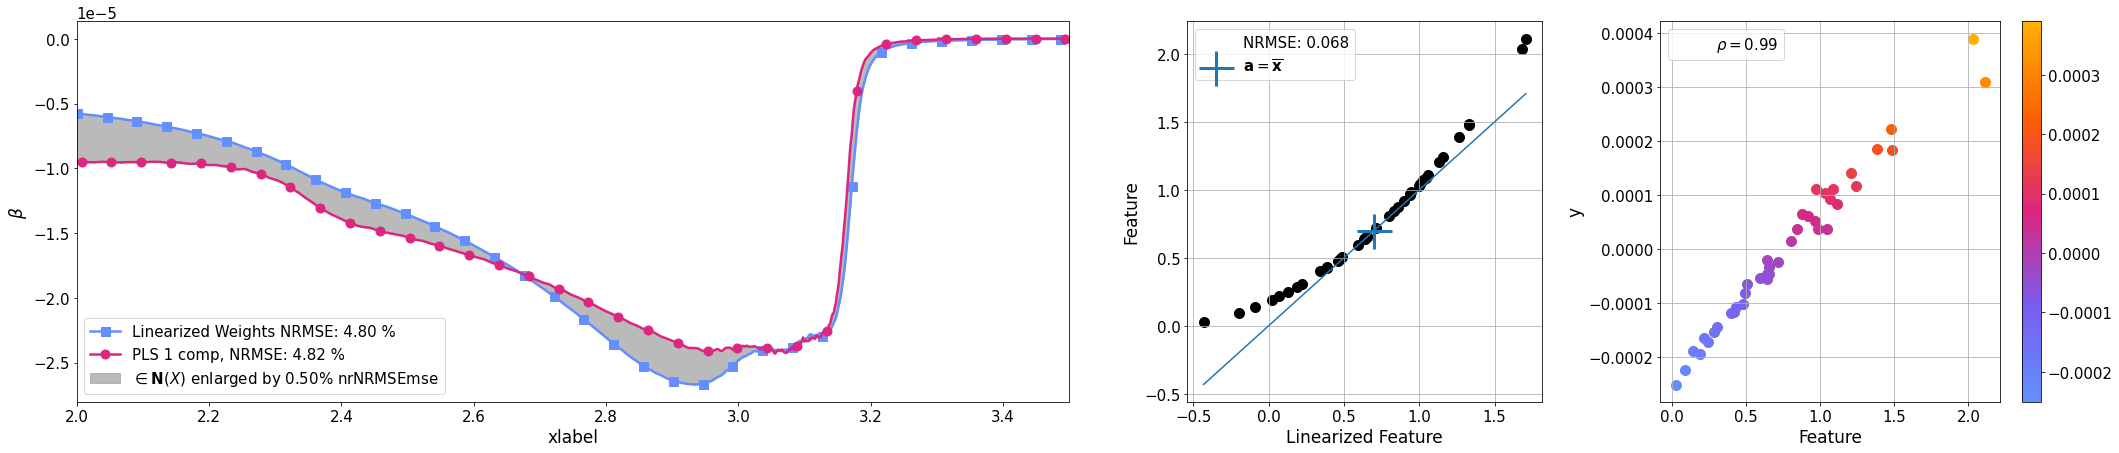

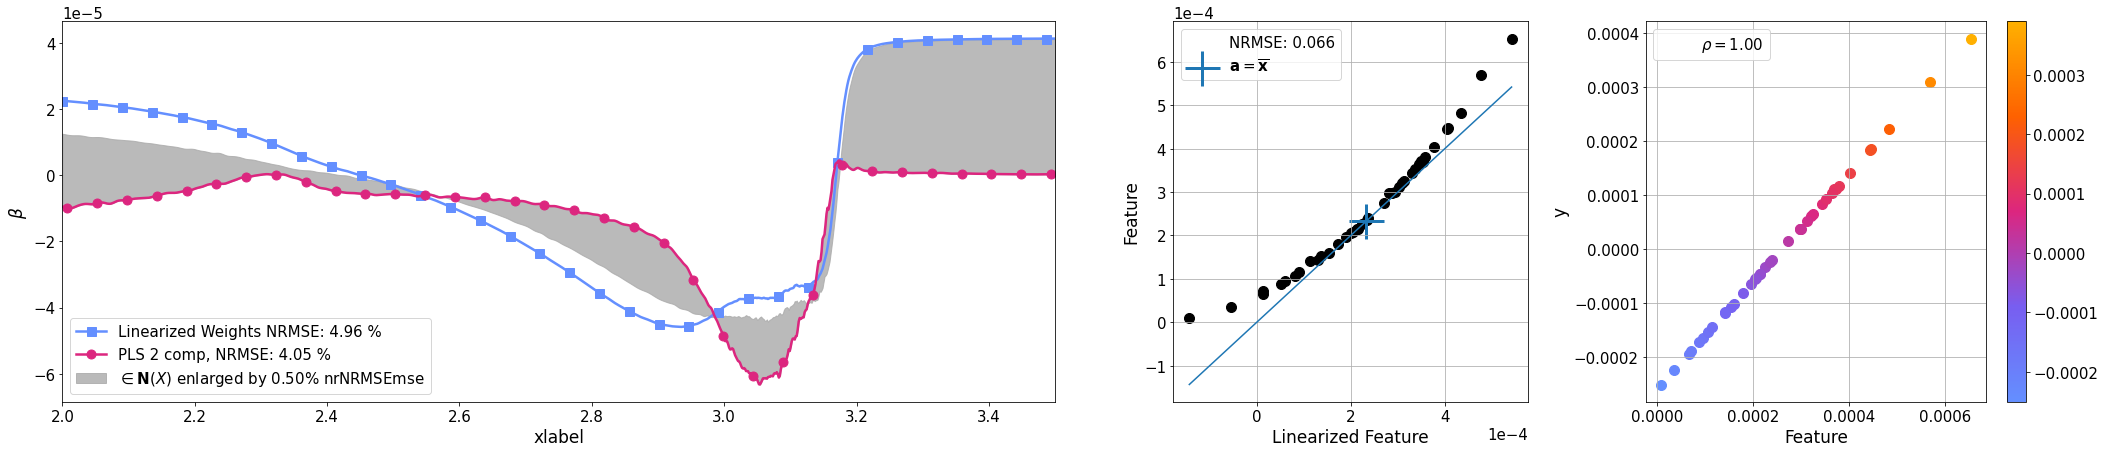

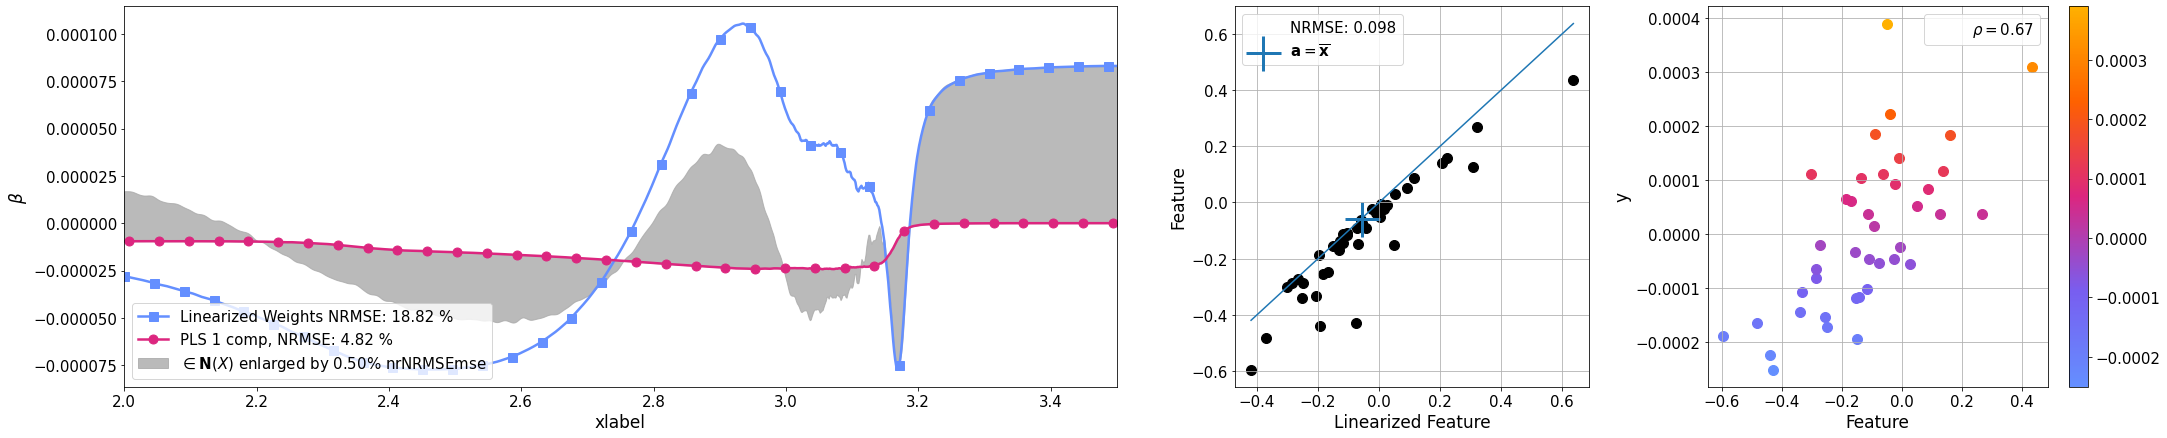

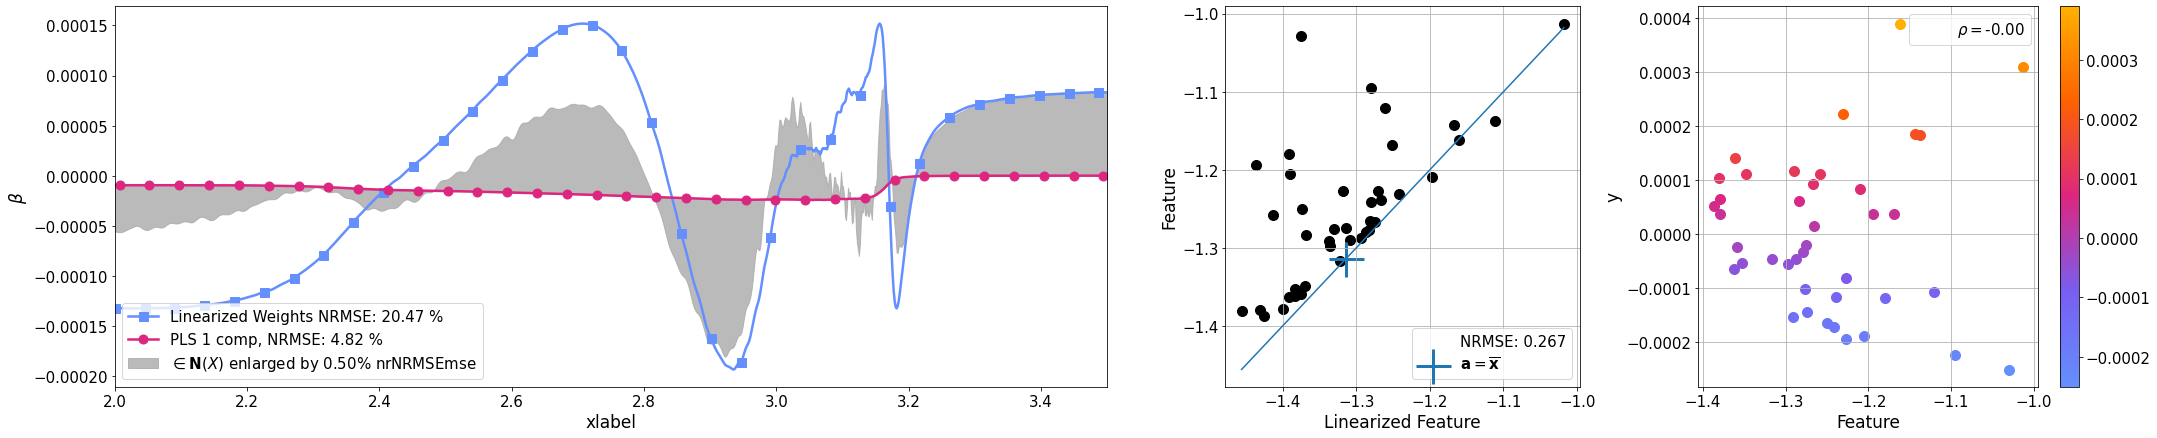

In [40]:
# Inititate the class with data (x, y) & features that you want to test
lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

# Run the tests
lfp_var_gt = lfp_var_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.50, opt_dist=1)
plt.show()

['PLS 1 comp', 'lfun']
inf
['PLS 1 comp', 'lfun']
inf
['PLS 1 comp', 'lfun']
0.00042279323193561424
0.00526574034516436
0.07428972579663373
0.7961805856835724
0.07428972579663373
0.14607900601718704
0.2771038180072054
0.4929702214431053
0.7961805856835724
0.4929702214431053
0.5614702906458504
0.4929702214431053
0.5095696960401241
0.4929702214431053
0.4970865865313634
0.5012253375394593
4
Gamma value corresponding to nrmse=0.50 % is 35.705
35.70543882619261
['PLS 3 comp', 'lfun']
0.0004158425679214872
0.0018818812260432694
0.1330364616728943
0.914816167167956
0.1330364616728943
0.26026742288752036
0.4355656935850307
0.6563054113092006
0.4355656935850307
0.48655534969612724
0.5403755830637351
0.48655534969612724
0.49974579064049074
0.5131129508535244
0.49974579064049074
0.5030710274630881
4
Gamma value corresponding to nrmse=0.50 % is 59.219
59.218982012703925
['PLS 1 comp', 'lfun']
0.0008280248839831472
0.0004614025183524717
0.012403393822159714
0.6281967925554586
0.012403393822159714
0

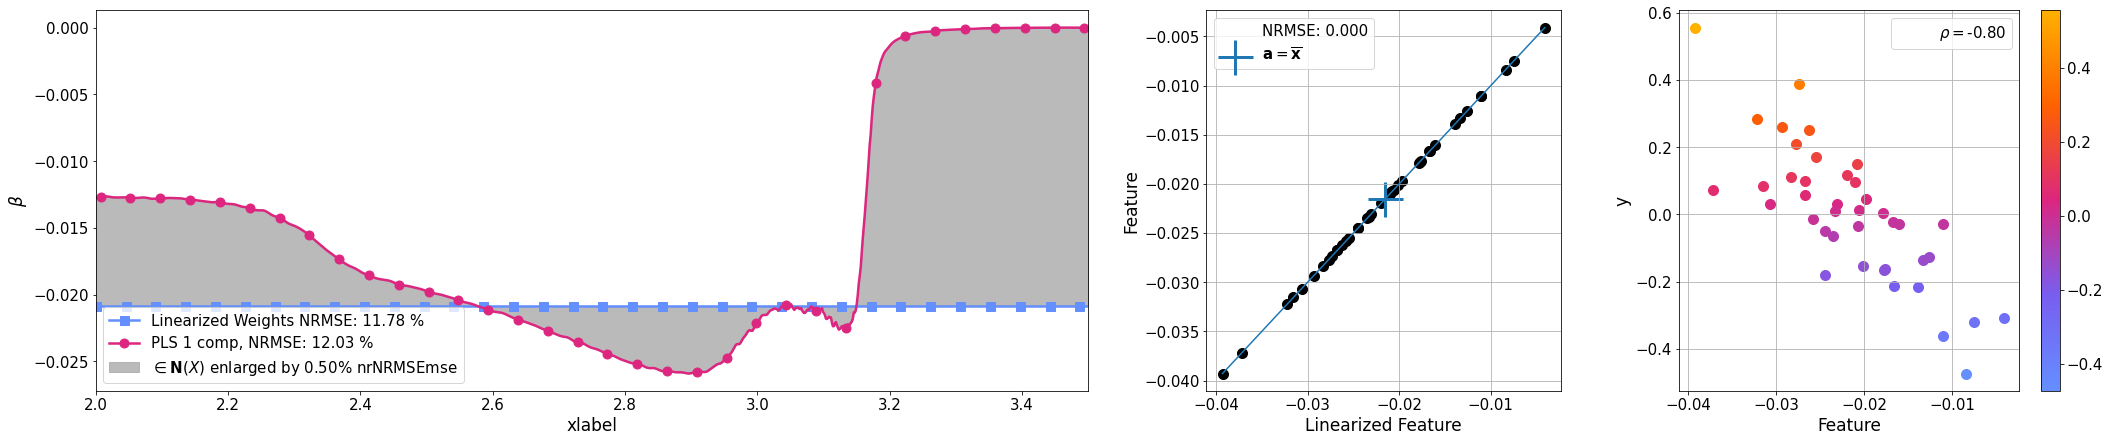

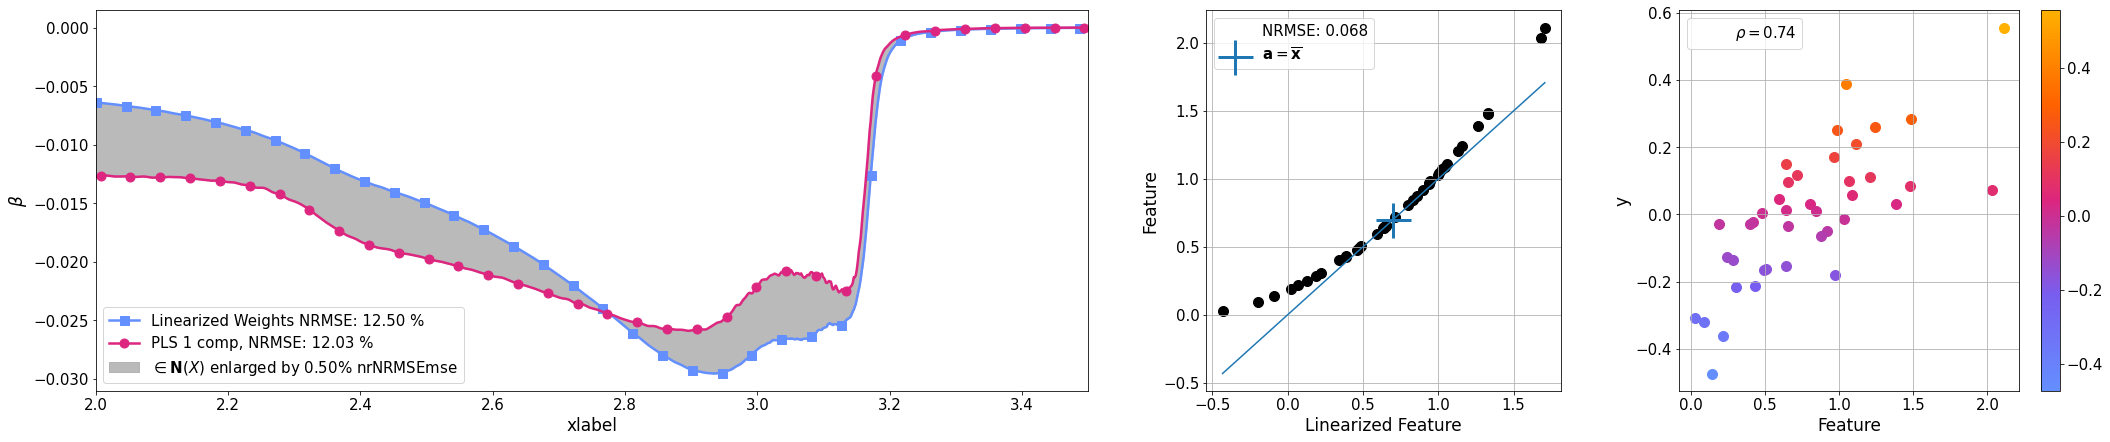

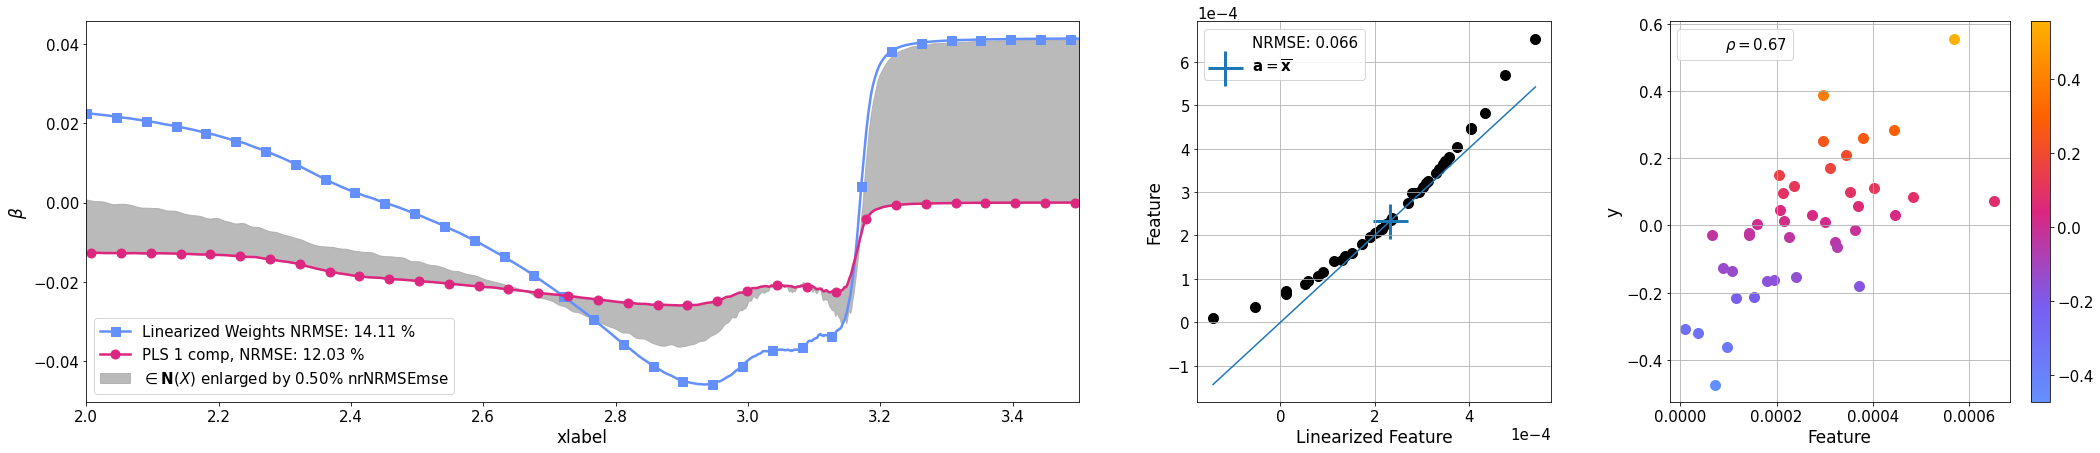

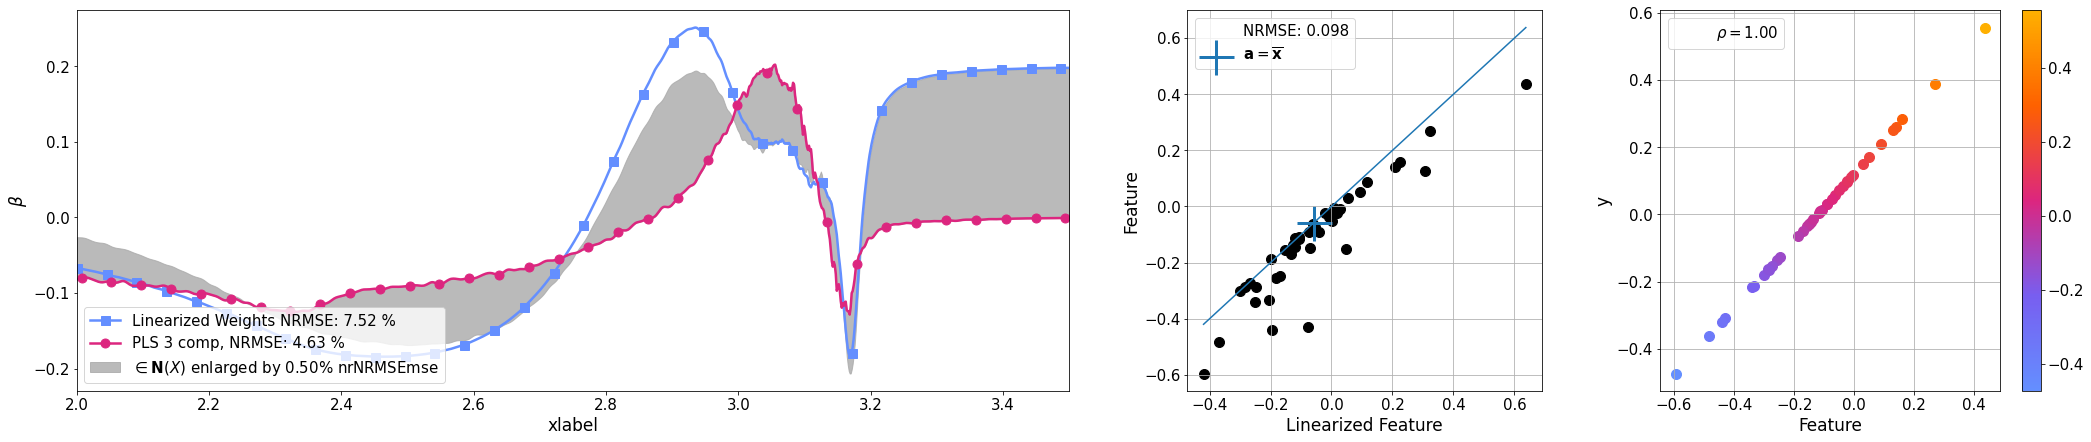

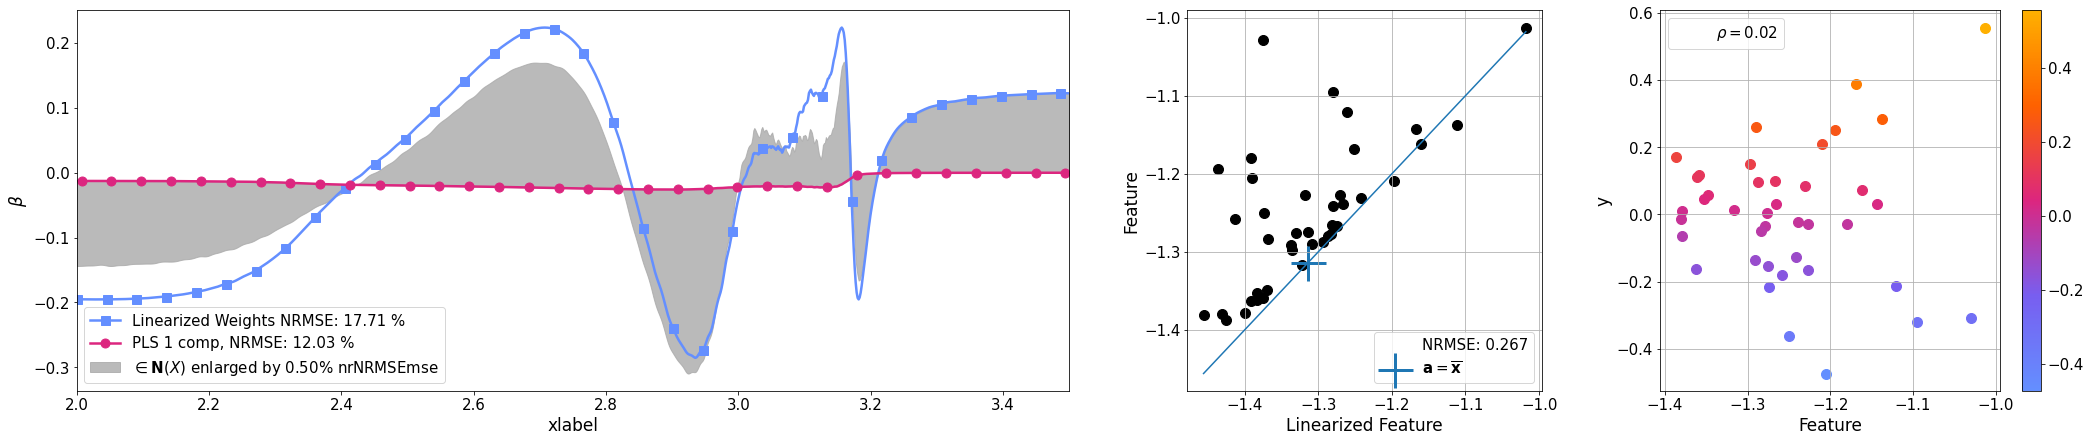

In [41]:
# Inititate the class with data (x, y) & features that you want to test
lfp_skew_gt = Featlin(data_obj=lfp_skew, feat_funcs=feat_fun_dict)

# Run the tests
lfp_skew_gt = lfp_skew_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.50, opt_dist=1)
plt.show()

['PLS 1 comp', 'lfun']
inf
['PLS 1 comp', 'lfun']
inf
['PLS 1 comp', 'lfun']
inf
['PLS 1 comp', 'lfun']
0.001676908202650651
0.017057226992797325
0.12412860075640708
1.0164395629206489
0.12412860075640708
0.23173730086327637
0.416843790833731
0.6903197140517534
0.416843790833731
0.47731005446245334
0.5433667092558316
0.47731005446245334
0.4933121803006806
0.5096598321712094
0.4933121803006806
0.49736691807406785
0.5014431678572215
4
Gamma value corresponding to nrmse=0.50 % is 58.557
58.556906454961705
['PLS 2 comp', 'lfun']
0.0049634166116039324
0.024238083527825083
0.0776865599906742
0.8142585105905571
0.0776865599906742
0.17027868765975462
0.28595612646143564
0.4720512287279668
0.8142585105905571
0.4720512287279668
0.5406531081330002
0.4720512287279668
0.4881884482579171
0.5049911021172839
0.4881884482579171
0.49232607865580214
0.49650556635425325
0.5007271605844146
4
Gamma value corresponding to nrmse=0.50 % is 33.754
33.75361655904026


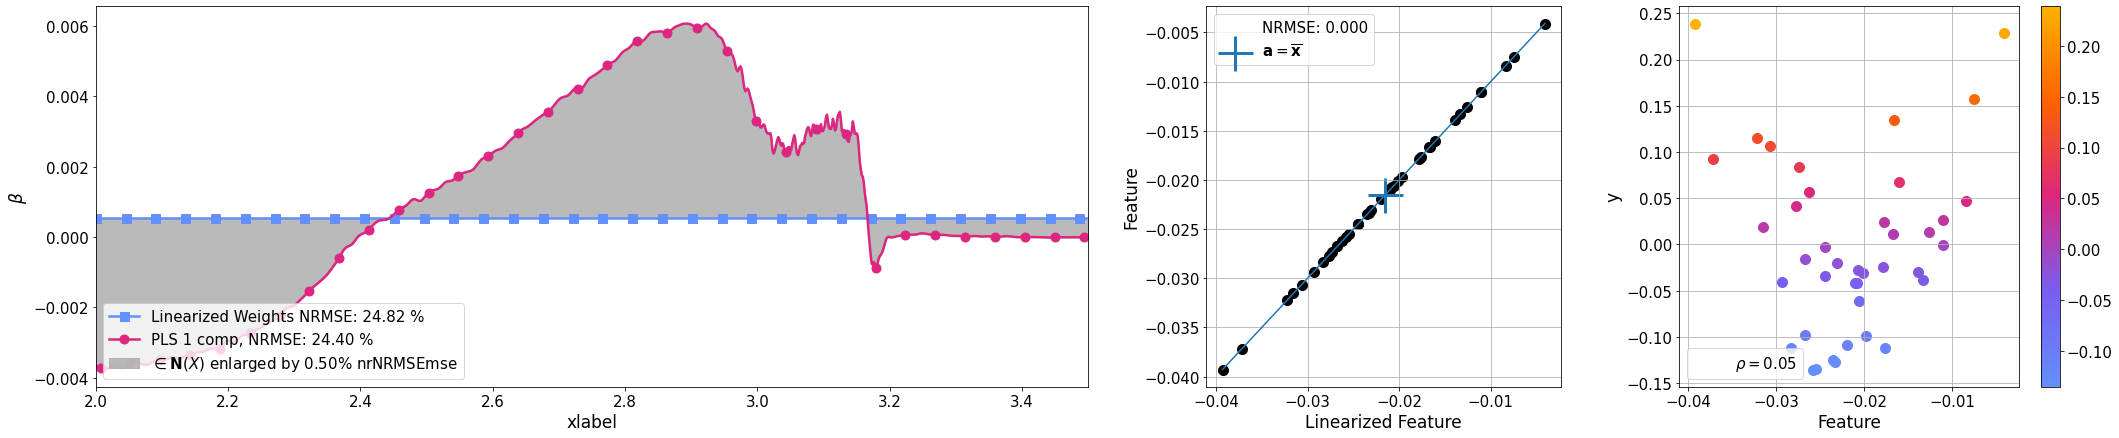

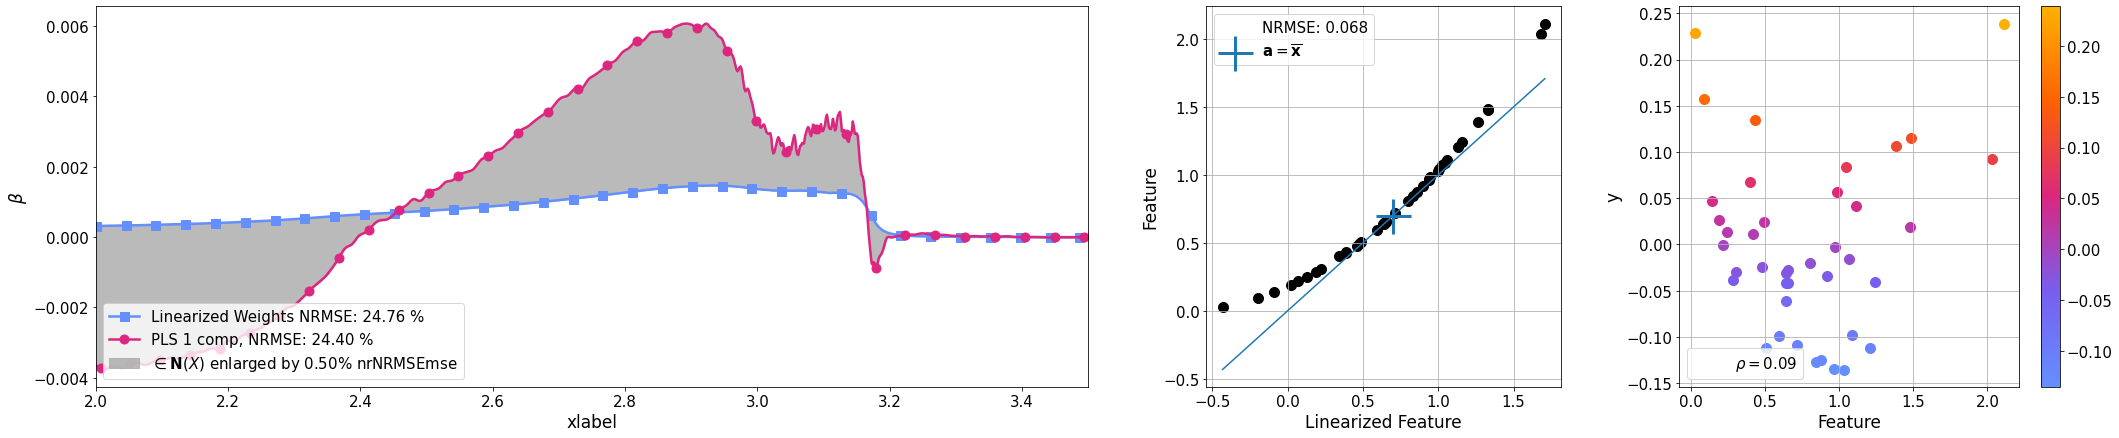

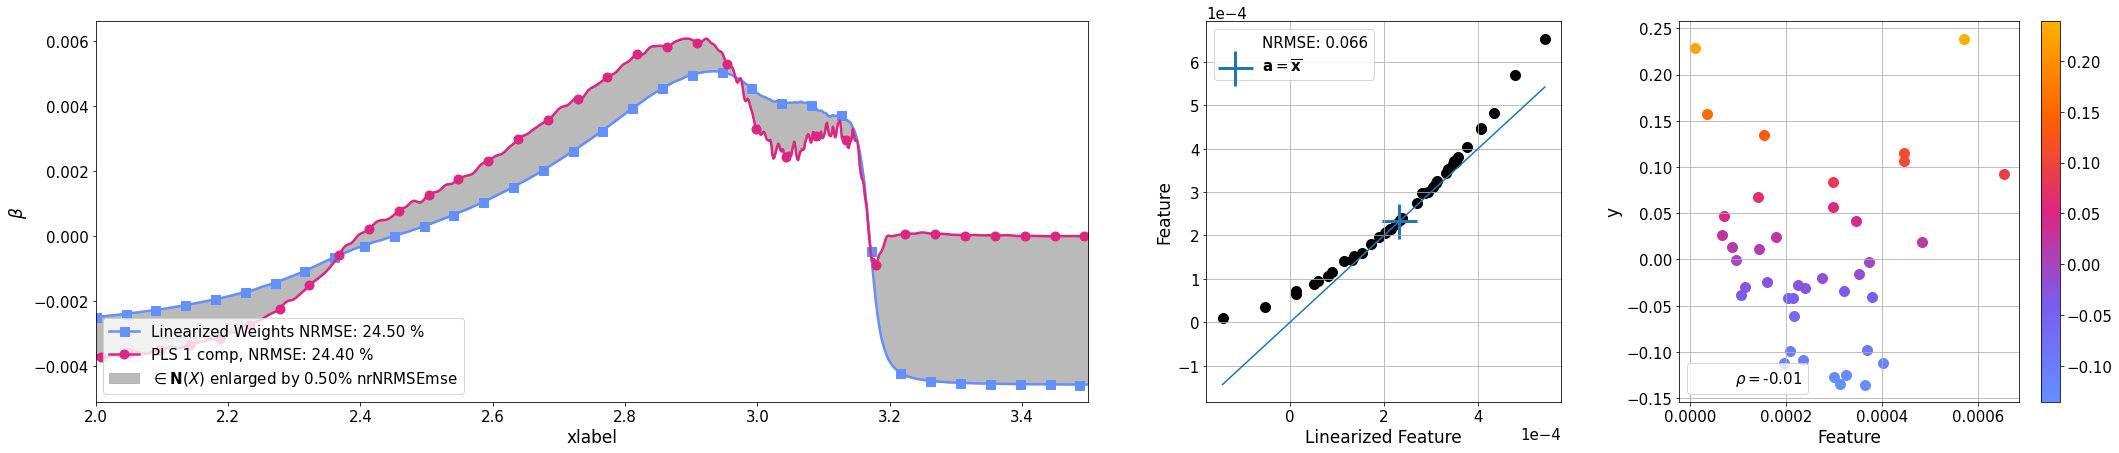

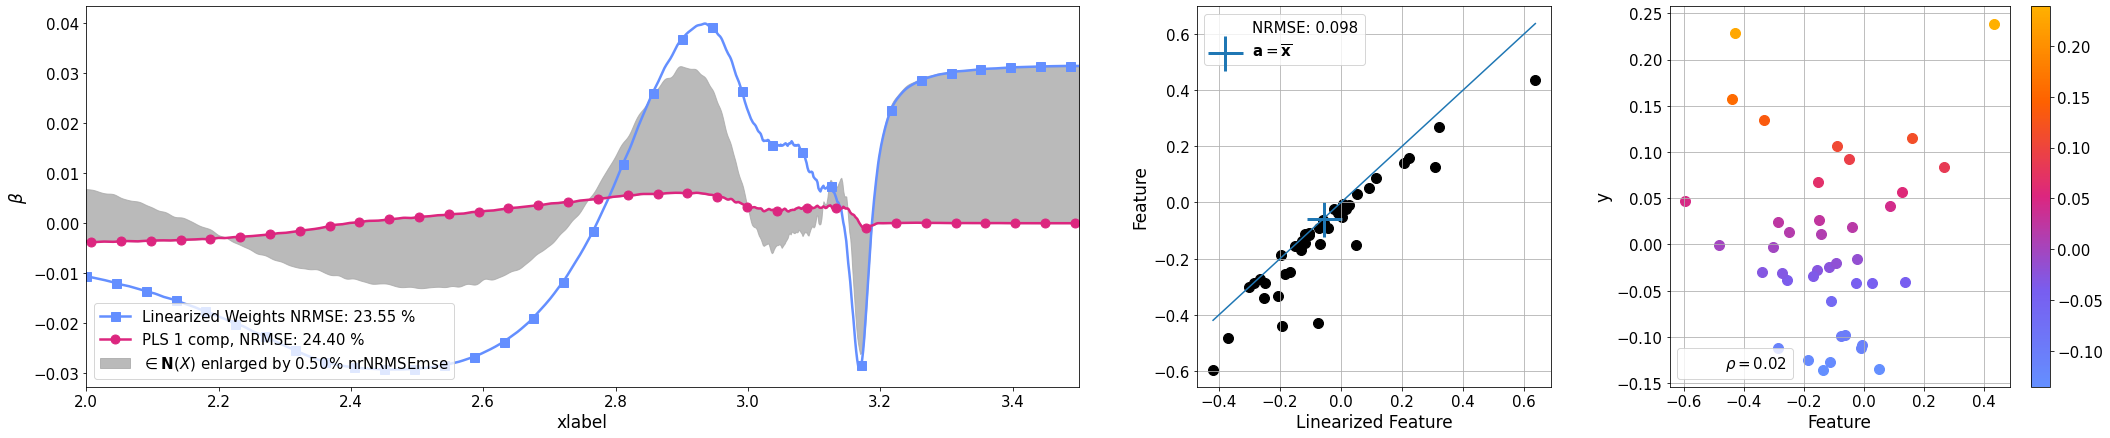

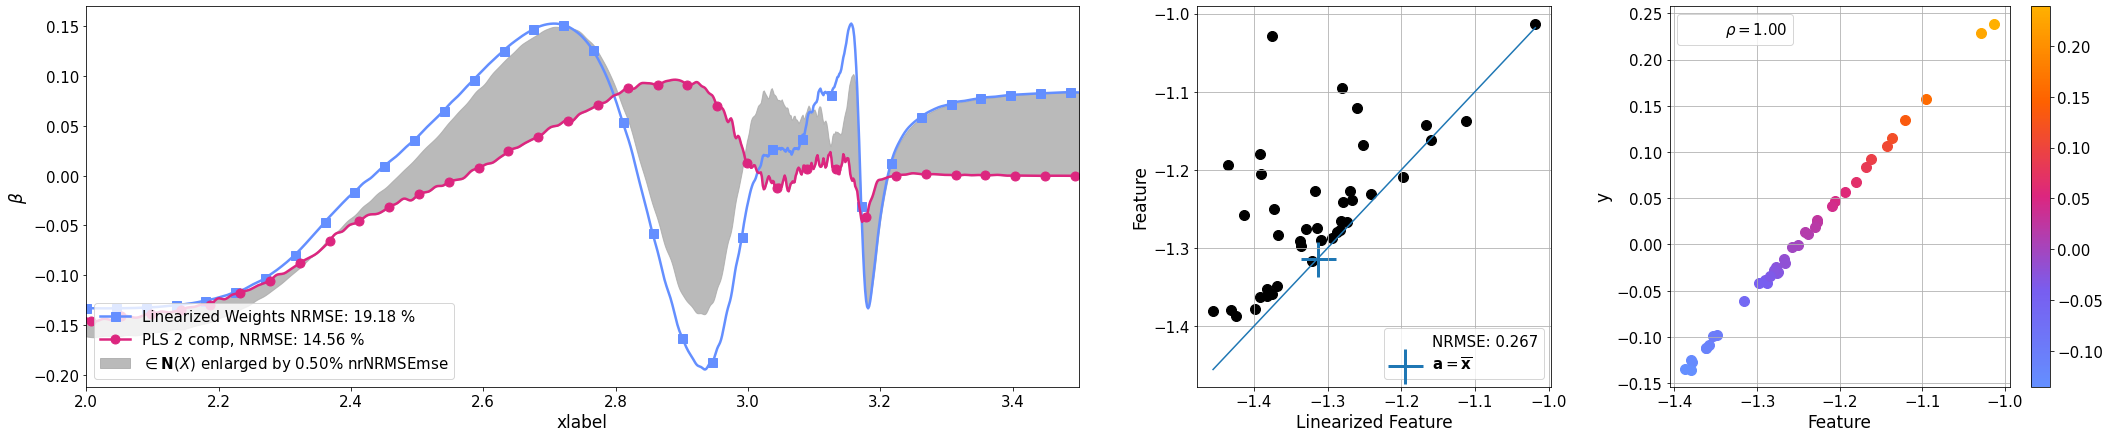

In [42]:
# Inititate the class with data (x, y) & features that you want to test
lfp_kurt_gt = Featlin(data_obj=lfp_kurt, feat_funcs=feat_fun_dict)

# Run the tests
lfp_kurt_gt = lfp_kurt_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.50, opt_dist=1)
plt.show()

In [ ]:
# 


# Test the results for feature selection
# TGest the results for sections

In [ ]:
# User experience: 

# Test cases
# 1. Linear dummy example
# 2. Nonlinear examples 
# 3. Nonlinear section examples
# 4. Real LFP data.
 

In [ ]:
def anlyse_features(
    X, x_lfp, y, fun_targetj, color_dict, 
    cv=1, include_cv_model=0, opt_nrmse=0, opt_dist=1, norm=1, 
    scatter=0, plot_cv=0, verbose=1, include_min_dist_model=1, max_nrmse=-0.5):
    ''' Function to anlayse features given certain data! (: '''

    # PLS 1 model is always selected as a reference. 
    # Models
    models = [
        PLSRegression(n_components=1, tol=1e-7, scale=False)
    ]
    model_names = [
        'PLS 1 comp'
    ]

    # Calculate the feature and linearized coef.
    x_hat, lin_coef_, lin_const_coef = regress_linearized_coeff(X, y, fun_targetj)


    if scatter:
        # Make a scatterpliot here, to see whats going on.
        # Where do you linearize? The more nonlinear the more outlier, the crappier this mehtod will be!
        # Whats the path regression coefficeints take with varying regularization?
        plt.scatter(X@lin_coef_.reshape(-1), y_gt[:, 1])
        plt.scatter(np.array([fun_targetj[1](X[i, :]) for i in range(X.shape[0])]), y_gt[:, 1])
        lin_sp = np.linspace(np.min(y_gt[:, 1]), np.max(y_gt[:, 1]), 10)
        plt.plot(lin_sp, lin_sp)

    # CV only for PLS!
    if cv:
        cv_dict = optimise_pls_cv(
            X, y, max_comps=10, plot_components=plot_cv, std=False, min_distance_search=True, featlin=lin_coef_)
        rmse_min_comp = cv_dict['components'][cv_dict['rmse_std_min']]
        if include_cv_model:
            models.append(PLSRegression(n_components=rmse_min_comp, tol=1e-7, scale=False),)
            model_names.append('PLS ' + str(rmse_min_comp) + ' comp')
            print(model_names)

    if opt_nrmse:
        nrmse_lin = 100*mean_absolute_percentage_error(y, X@lin_coef_.reshape(-1))
        alpha = optimize_regcoef_nrmse('ridge', X, y, [10**5, 10**(-5)], nrmse_lin+1.5, max_depth=10)
        models.append(Ridge(alpha=alpha))
        model_names.append(f" RR: {alpha:.2f}")

    if opt_dist:
        alpha = optimize_regcoef_dist('ridge', X, y, [10**5, 10**(-5)], lin_coef_, norm=1, max_depth=10)
        # models.append(Ridge(alpha=alpha))
        # model_names.append(f" RR: {alpha:.2f}")

        comp = optimize_regcoef_dist('PLS', X, y, [10], lin_coef_, norm=1, max_depth=10)
        print('opt_dict')
        # Ensures that this is the last list item by removing previous identical entries. 
        if f"PLS {comp} comp" in model_names:
            id = model_names.index(f"PLS {comp} comp")
            model_names.remove(f"PLS {comp} comp")
            print(id)
            models.pop(id)
            # models.remove(PLSRegression(n_components=comp, tol=1e-7, scale=False))
            models.append(PLSRegression(n_components=comp, tol=1e-7, scale=False))
            model_names.append(f"PLS {comp} comp")
                
    
    model_dict = {'models': models, 'model_names': model_names}
    label_dict = {'xlabel': 'Voltage (V)'}
    print(model_dict['model_names'])
    fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [7, 3, 3]}, figsize=(36,7))
    linearization_regeression_row_plots(
        X, x_lfp, y, fun_targetj, axs, cmap, model_dict, color_dict, label_dict,
        nullspace_corr=True, plot_nullspace_bool=False, max_nrmse=max_nrmse)
    # plt.show()

    return fig, axs

In [ ]:
models = pd.DataFrame(columns=['a', 'b'])
models.loc[1] = ['lin']
models

In [ ]:
# Make 2 plots + list of \gamma values telling the user how much deviation from the nullspace is necessary. 
# Then move on to the more complicated examples.
# Fix the standard deviation rule, this should help to avoid the nasty area.

# Note that because we use a linear feature we use the crossvalidated 1std rule to determine the feature.
# IF the feature would be nonlinear, we should be more conservative and use the min_dist_model. 
# The reason therefore is that PLS and other regression models must try to linearly capture nonlinearity. 
# This often results in more spicky regression coefficients that are expected to deviate from the linearized coefficients.

color_dict = {'color_list': color_list, 'marker_list': marker_list}
fig, ax = anlyse_features(
    X, x_lfp, y_gt[:, 0], fun_targetj[0], color_dict, color_dict, plot_cv=True, 
    include_cv_model=1, include_min_dist_model=0, max_nrmse=1)
fig.suptitle('Test')
plt.show()

In [ ]:
anlyse_features(
    X, x_lfp, y_gt[:, 0], fun_targetj[1], color_dict, color_dict, plot_cv=0, max_nrmse=1,
    include_cv_model=1, include_min_dist_model=0)

In [ ]:
anlyse_features(
    X, x_lfp, y_gt[:, 0], fun_targetj[2], color_dict, color_dict, plot_cv=0, max_nrmse=5,
    include_cv_model=1, include_min_dist_model=0)

In [ ]:
anlyse_features(X, x_lfp, y_gt[:, 3], fun_targetj[3], color_dict, color_dict)

In [ ]:
anlyse_features(X, x_lfp, y_gt[:, 4], fun_targetj[4], color_dict, color_dict)

# Large Map of Results

In [ ]:
from importlib import reload
reload(src.featlin)
from src.featlin import linearization_plots

models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
    PLSRegression(n_components=2, tol=1e-7, scale=False),
    # PLSRegression(n_components=3, tol=1e-7, scale=False), 
    Ridge(alpha=0.3)
]
model_names = [
    'PLS 1 comp',
    'PLS 2 comp',
    # 'PLS 3 comp',
    r'Ridge Regression, $\alpha=0.3$'
]

fig, axs = linearization_plots(x_lfp,  X_lfp_train, y_gt, fun_targetj, fun_target_names, models, model_names, labels_lfp, cmap, show=False)

# Plot Test, Test 2 into axs[0, 0]\
axs[0, 0].plot(x_lfp, X_lfp_test2[:, :].T, label='Sec. Test', lw=1, color=color_list[2])
axs[0, 0].plot(x_lfp, X_lfp_test[:, :].T, label='Prim. Test', lw=1, color=color_list[1])
axs[0, 0].plot(x_lfp, X_lfp_train[:, :].T, label='Train', lw=1, color=color_list[0])
handles, labels = axs[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0, 0].legend(by_label.values(), by_label.keys(), loc=3)

plt.show()

# RDB What would be useful in your opinoin?
# Insert additional plots for  axs[1, 1] and axs[1, 2] in here. 
# Correlation of each column to y
# Train and test dataset correlations ( one plot per test)


In [ ]:
def reject_outliers(data, m = 2.):
    '''
    https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
    Answer from Benjamin Bannier
    '''
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m], s<m

In [ ]:
d = {'ashfkjlrg':1, 'bgadsrjklr':2}

In [ ]:
d.keys()

In [ ]:
# Now without the outlier's (; 
X_lfp_train_filtered_mean, ind =  reject_outliers(np.mean(X_lfp_train, axis=1), m = 2.5)


models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
    PLSRegression(n_components=2, tol=1e-7, scale=False),
    PLSRegression(n_components=3, tol=1e-7, scale=False), 
    #Ridge(alpha=0.3)
]
model_names = [
    'PLS 1 comp',
    'PLS 2 comp',
    'PLS 3 comp',
    #r'Ridge Regression, $\alpha=0.3$'
]

fig, axs = linearization_plots(x_lfp,  X_lfp_train[ind, :], y_lfp_train[ind, :], fun_targetj, fun_target_names, models, model_names, labels_lfp, cmap, show=False)

In [ ]:
# LFP with real labels (:
reload(src.featlin)
from src.featlin import linearization_plots

models = [
    PLSRegression(n_components=1, tol=1e-7, scale=False),
    # PLSRegression(n_components=2, tol=1e-7, scale=False),
    #PLSRegression(n_components=3, tol=1e-7, scale=False), 
    Ridge(alpha=0.3)
]
model_names = [
    'PLS 1 comp',
    # 'PLS 2 comp',
    #'PLS 3 comp',
    r'Ridge Regression, $\alpha=0.3$'
]

fig, axs = linearization_plots(x_lfp,  X_lfp_train, y_lfp_train_true, fun_targetj, fun_target_names, models, model_names, labels_lfp, cmap, show=False)

In [ ]:
def plot_axs(x,  X_train_, X_test_, y_train_, fun_targetj, alpha):
    ''' Function to create plot of data and regression coefficients
    '''
    colors = ['#0051a2', '#97964a', '#f4777f', '#93003a']
    rows = len(fun_targetj) + 2
    columns = X_train_.shape[2]+1
    figsize = [10*columns, 6*rows]

    fig, axs = plt.subplots(rows, columns, figsize=figsize, sharex=True)

    axs[0, 0].plot(x, X_train_[:, :, 0].T, label='Train Data', lw=1, color=colors[0])
    axs[0, 0].plot(x, X_test_[:, :, 0].T, label='Test Data', lw=1, color=colors[1])
    axs[0, 1].plot(x, X_train_[:, :, 0].T, label='Train Data', lw=1, color=colors[0])
    axs[0, 1].plot(x, X_test_[:, :, 0].T, label='Test Data', lw=1, color=colors[1])
    # axs[0, 1].plot(x, X_train_[:, :, 1].T, label='Train Data', lw=1, color=colors[0])
    # axs[0, 1].plot(x, X_test_[:, :, 1].T, label='Test Data', lw=1, color=colors[1])
    # axs[0, 2].plot(x, X_train_[:, :, 2].T, label='Train Data', lw=1, color=colors[0])
    # axs[0, 2].plot(x, X_test_[:, :, 2].T, label='Test Data', lw=1, color=colors[1])
    axs[1, 0].plot(x, np.abs(np.mean(X_train_[:, :, 0].T, axis=1)), label='|Mean Train|', lw=1, color=colors[0])
    axs[1, 0].plot(x, np.std(X_train_[:, :, 0].T, axis=1), label='Std Train', lw=1, color=colors[1])
    axs[1, 1].plot(x, np.abs(np.mean(X_train_[:, :, 0].T, axis=1)), label='|Mean Train|', lw=1, color=colors[0])
    axs[1, 1].plot(x, np.std(X_train_[:, :, 0].T, axis=1), label='Std Train', lw=1, color=colors[1])
    axs[1, 0].legend()
    axs[1, 1].legend()
    
    for i in range(X_train_.shape[2]):
        handles, labels = axs[0, i].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axs[0, i].legend(by_label.values(), by_label.keys(), loc=2, fontsize=22)

    for i in range(X_train_.shape[2]):
        for j in range(y_train_.shape[1]):
            X_train = X_train_[:, :, i]
            y_train = y_train_[:, j, i]
            pls1 = PLSRegression(n_components=1, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            pls2 = PLSRegression(n_components=2, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            pls3 = PLSRegression(n_components=3, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            pls4 = PLSRegression(n_components=4, tol=1e-7, scale=False).fit(X_train, y_train-y_train.mean())
            rr = Ridge(alpha=alpha).fit(X_train, y_train-y_train.mean())

            x_hat, lin_coef_, lin_const_coef = regress_linearized_coeff(X_train, y_train, fun_targetj[j])
            axs[j+2, i].plot(x, lin_coef_.reshape(-1), label=r'$\beta_{Lin}$', lw=2.5, color=colors[0], marker="s", markevery=(1, 30),  markersize=9)
            axs[j+2, i+1].plot(x, lin_coef_.reshape(-1), label=r'$\beta_{Lin}$', lw=2.5, color=colors[0], marker="s", markevery=(1, 30),  markersize=9)
            axs[j+2, i].plot(x, pls1.coef_, label=r'$\beta_{PLS}$, 1 Component', lw=2.5, color=colors[1], marker="o", markevery=(10, 30), markersize=9)
            axs[j+2, i].plot(x, pls2.coef_, label=r'$\beta_{PLS}$, 2 Component', lw=2.5, color=colors[2], marker="D", markevery=(15, 30), markersize=9)
            axs[j+2, i+1].plot(x, pls2.coef_, label=r'$\beta_{PLS}$, 2 Component', lw=2.5, color=colors[2], marker="D", markevery=(15, 30), markersize=9)
            axs[j+2, i+1].plot(x, pls3.coef_, label=r'$\beta_{PLS}$, 3 Component', lw=2.5, color=colors[3], marker="D", markevery=(20, 30), markersize=9)
            axs[j+2, i+1].plot(x, pls4.coef_, label=r'$\beta_{PLS}$, 4 Component', lw=2.5, color=colors[1], marker="D", markevery=(25, 30), markersize=9)
            axs[j+2, i].plot(x, rr.coef_, label=r'$\beta_{RR}$  $\lambda=0.5$', lw=2.5, color=colors[3], marker="P", markevery=(20, 30),  markersize=9)
            
            # axs.grid()
            handles1, labels1 = axs[j+1, i].get_legend_handles_labels()
            by_label1 = dict(zip(labels1, handles1))
            handles2, labels2 = axs[j+1, i+1].get_legend_handles_labels()
            by_label2 = dict(zip(labels2, handles2))
            axs[j+2, i].legend(by_label1.values(), by_label1.keys(), loc=2, fontsize=16)
            axs[j+2, i+1].legend(by_label2.values(), by_label2.keys(), loc=2, fontsize=16)
            
            axs[j+2, i].set_title(fun_target_names[j])
            axs[j+2, i+1].set_title(fun_target_names[j])

    plt.tight_layout()
    plt.show()
            
    return None

In [ ]:
# IPython Libraries
import IPython
import ipywidgets
from ipywidgets import interact, fixed

scaler = preprocessing.StandardScaler().fit(X_lfp_train)
X_scaled = scaler.transform(X_lfp_train)
interact(plot_axs, x=fixed(np.linspace(3.5, 2.0, 1000)),  X_train_=fixed(np.expand_dims(X_lfp_train, axis=2)), 
        X_test_=fixed(np.expand_dims(X_lfp_test, axis=2)), y_train_=fixed(y_lfp_train), fun_targetj=fixed(fun_targetj),
        alpha=ipywidgets.FloatLogSlider(value = 0.5,
                                    base = 2,
                                    min=-10, 
                                    max=10, 
                                    step=0.0001, 
                                    description='Alpha RR',
                                    continuous_update=True)
                                    )

In [ ]:
# Why don't the linear methods point into the directions that would be ideal?  
# The effect of 'outliers' ?

# Even in an ideal world this will not work too well. 
# Reasons: 
# 1. Nullspace of the data, 
# 2. The way of regularization will affed the shape of the coefficiencts a lot. 
# IF there's some linear order, the algorithms will always learn coefficients that have a similar shape as the data!
# How much are the algorithms affected by outliers? 
# How much are the algorithms affected by not standardizing the data
# How much does correlation between columns affect the results? 

# --> Conclusion: Interesting new perspective on interpretation of regression coefficients. 
# How do regression coeffcieints compare with standardizartion and without?

# Negative regression coefficients: This is NOT an issue. Might be simply because of the y-y.mean(). 
# How and when does the sign of regression coefficients flip?


# Conclusions: It can give you some directions that might be interesting. 
# HOWEVER: Regression coefficients often look similar to the data... 
# Why is this the case? 
# --> Because the data is not standardized, we apply an implicicit preference larger weights on regions that with a larger mean/std 
# Thsi regiosn might also contiana more information, but deu to the way how regularization is done, if the regions where the magnitude of the data is smaller 
# doesnt carry significatly more information, those will go to zero//they might be eassier to regularize down.

# Common issues with such datasets: 
# Correlation of columns. 

# Hyperparamter: How to find the right hyperparamter?
# PLS with its integer hyperparamters might not be ideal

# Idea: Tune RR hyperparamter to optimize the fit of th regression coefficient with the feature as a measure. 
# (Metric based on the difference of the prediction, or simpoly apply some nullspace trick)

# You can get around the issue of hyperparamter tuning by only using the first 1 or 2 PLS components.

In [ ]:
# Key Questions: 

# 1. Linear examples: Show that it works with CV
# 2. Nonlinear example, show that it wokrs with CV BUT might require nullspace. 
# 3. Was there a big eefect on whether the outlier is included or not? Leave it in if not.
# 3. How to do CV? RR or PLS? IF PLS: Can we just pretune and then finetune? 

# Is CV even the right wauy?
# Conservative estimates might be better/more apporpriate.

# Reworke the Nullspace code. 
# Decide on how it shall be decided. Tolerable nrmse? (this could be stiamted based on the noise that is present in the data, difference between resutls of splits etc.)
